#  Applied Data Science Capstone Project: City Comparison

This is the Jupyter notebook for the Capstone Final Project of the Coursera specialization: 
<br>
### IBM Applied Data Science 
<hr>

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Scrape and Process Data from Los Angeles, San Francisco and New York City</a> 

2. <a href="#item2">Explore Neighborhoods in Each City</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Plotting Clusters</a>    

6. <a href="#item6">Comparison between cities</a>  
</font>
</div>

<hr>

<div class="alert alert-block alert-info" style="margin-top: 20px">

### Initializations: Import libraries

</div>

In [713]:
import requests # library to grab html data

from bs4 import BeautifulSoup # library to scrape html data

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# use the inline backend to generate the plots within the browser
#%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt


from sklearn.cluster import KMeans # import k-means from clustering stage
from scipy.spatial import distance # library to compute distances between vectors

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

<hr><hr>

<div class="alert alert-block alert-info" style="margin-top: 20px">

### Part 1: Scraping neighborhood postal codes and names from wikipedia pages for several cities <a name="item1"></a>

</div>

---

### Los Angeles (Part 1) - Neighborhoods

In [714]:
# 1. Define the URL link
web_link="http://www.laalmanac.com/communications/cm02_communities.php"

# 2. Use request.get to download the data from the wikipedia site and assign the data to the variable wikipedia_data
web_data= requests.get(web_link)

# 3. Use the data attribute text to extract the html data as text string, parse it with BeautifulSoup function
# and assign to the variable soup
page=web_data.text

# 4. Find relevant postalcode data in a html table using .find_all('table') function
soup = BeautifulSoup(page, 'html.parser')

# 5. Find relevant postalcode data in a html table using .find_all('table') function
table = soup.find_all('table')[0]

# 6. Parse, extract table information and convert to pandas dataframe using pd.read_html function 
df = pd.read_html(str(table), header=0)[0]

# 7. To merge neighborhoods/cities with common names, first we extract first word of each neighborhood name and copy 
# to separate column 'First'
df[['First']] = df[['City/Community']].apply(lambda x: x.str.split().str[0])

# 8. Group neighborhoods with same name in column 'First' and aggregate the postal codes
la_neighborhoods = df.groupby(['First']).agg(lambda x: ', '.join(x.values))

# 9. Reset index and drop 'First' column
la_neighborhoods.reset_index(inplace = True)
la_neighborhoods = la_neighborhoods.drop(['First'], axis=1)

# 10. Keep just first zipcode per neighborhood
la_neighborhoods[['Zip Code(s)']] = la_neighborhoods[['Zip Code(s)']].apply(lambda x: x.str.split().str[0])
la_neighborhoods['Zip Code(s)'] = la_neighborhoods['Zip Code(s)'].str.replace(',', '')

# 11. Adjust column names 
la_neighborhoods = la_neighborhoods.rename(columns={'City/Community':'Neighborhood' , 'Zip Code(s)': 'Zip Code'})

# 13. Remove duplicates
la_neighborhoods.drop_duplicates(['Zip Code'], keep='first', inplace=True)

# 12. Keep only zipcodes with 90XXX and reset index again
la_neighborhoods =  la_neighborhoods[(pd.to_numeric(la_neighborhoods['Zip Code'])<91000)]
la_neighborhoods = la_neighborhoods.reset_index(drop=True)

In [715]:
print("Number of neighborhoods in LA: " + str(la_neighborhoods.shape[0]))

la_neighborhoods.head()

Number of neighborhoods in LA: 91


,Neighborhood,Zip Code
0,Arlington Heights (Los Angeles),90019
1,"Artesia, Artesia (PO Boxes)",90701
2,Athens,90044
3,Atwater Village (Los Angeles),90039
4,Avalon (PO Boxes),90704


---

### San Francisco (Part 1) - Neighborhoods

In [716]:
# 1. Define the URL link
web_link="http://www.healthysf.org/bdi/outcomes/zipmap.htm"

# 2. Use request.get to download the data from the wikipedia site and assign the data to the variable wikipedia_data
web_data= requests.get(web_link)

# 3. Use the data attribute text to extract the html data as text string, parse it with BeautifulSoup function
# and assign to the variable soup
page=web_data.text

# 4. Find relevant postalcode data in a html table using .find_all('table') function
soup = BeautifulSoup(page, 'html.parser')

# 5. Find relevant postalcode data in a html table using .find_all('table') function
table = soup.find_all('table')[3]

# 6. Parse, extract table information and convert to pandas dataframe using pd.read_html function 
sf_neighborhoods = pd.read_html(str(table), header=0)[0]

# 7 Drop last row and last column
sf_neighborhoods.drop(sf_neighborhoods.tail(1).index,inplace=True)
sf_neighborhoods.drop(sf_neighborhoods.columns[[-1,]], axis=1, inplace=True)

sf_neighborhoods = sf_neighborhoods.reindex(columns=['Neighborhood', 'Zip Code'])

In [717]:
print("Number of neighborhoods in SF: " + str(sf_neighborhoods.shape[0]))

sf_neighborhoods.head()

Number of neighborhoods in SF: 21


,Neighborhood,Zip Code
0,Hayes Valley/Tenderloin/North of Market,94102
1,South of Market,94103
2,Potrero Hill,94107
3,Chinatown,94108
4,Polk/Russian Hill (Nob Hill),94109


---

### New York (Part 1) - Neighborhoods

In [718]:
# 1. Define the URL link
web_link="https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm"

# 2. Use request.get to download the data from the wikipedia site and assign the data to the variable wikipedia_data
web_data= requests.get(web_link)

# 3. Use the data attribute text to extract the html data as text string, parse it with BeautifulSoup function
# and assign to the variable soup
page=web_data.text

# 4. Find relevant postalcode data in a html table using .find_all('table') function
soup = BeautifulSoup(page, 'html.parser')

# 5. Find relevant postalcode data in a html table using .find_all('table') function
table = soup.find_all('table')[0]

# 6. Parse, extract table information and convert to pandas dataframe using pd.read_html function 
ny_neighborhoods = pd.read_html(str(table), header=0, flavor='html5lib')[0]

# 7. Replace 'NaN' in 'ZIP Codes' column by content in 'Neighborhood' column and copy it to 'Zip Code' column
ny_neighborhoods['Zip Code'] = ny_neighborhoods['ZIP Codes']
ny_neighborhoods['Zip Code'] = np.where(ny_neighborhoods['ZIP Codes'].astype(str) == 'nan', ny_neighborhoods['Neighborhood'], ny_neighborhoods['ZIP Codes'])

# 8. Replace the content in column 'Neighborhood' where the 'Zip Code' is 'NaN' by content in 'Borough' column 
ny_neighborhoods['Neighborhood'] = np.where(ny_neighborhoods['ZIP Codes'].astype(str) == 'nan', ny_neighborhoods['Borough'], ny_neighborhoods['Neighborhood'])

# 9. Drop 'Borough' column and duplicate column 'ZIP Codes'
ny_neighborhoods.drop(['Borough','ZIP Codes'], axis=1, inplace= True)

# 10. Keep just first zipcode per neighborhood
ny_neighborhoods[['Zip Code']] = ny_neighborhoods[['Zip Code']].apply(lambda x: x.str.split().str[0])
ny_neighborhoods['Zip Code'] = ny_neighborhoods['Zip Code'].str.replace(',', '')

# 13. Remove duplicates
ny_neighborhoods.drop_duplicates(['Zip Code'], keep='first', inplace=True)


In [719]:
print("Number of neighborhoods in NY: " + str(ny_neighborhoods.shape[0]))

ny_neighborhoods.head()

Number of neighborhoods in NY: 42


,Neighborhood,Zip Code
0,Central Bronx,10453
1,Bronx Park and Fordham,10458
2,High Bridge and Morrisania,10451
3,Hunts Point and Mott Haven,10454
4,Kingsbridge and Riverdale,10463


<hr><hr>

<div class="alert alert-block alert-info" style="margin-top: 20px">

### Part 2: Acquiring longitude and latitude coordinates for each neighborhood in each city <a name="item2"></a>
</div>

In [720]:
# Return only US adresses
geolocator = Nominatim(format_string="%s, USA")

C:\Users\JAIONEAzpiroz\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


---

### Los Angeles (Part 2) - Coordinates

In [721]:
# Using geolocator to extract latitude and longitude data for each zip code whenever available
for n,zipcode in enumerate(la_neighborhoods['Zip Code']):
    address = zipcode
    location = geolocator.geocode(address)
    #print(location)
    if (location != None):
        latitude = location.latitude
        longitude = location.longitude
    else:
        latitude =  np.nan
        latitude =  np.nan
    #print('line = '+str(n)+'=> Zip Code= '+str(zipcode) +', lat= '+ str(latitude) +', long= '+ str(longitude))
    la_neighborhoods.loc[la_neighborhoods.index[n], 'Latitude'] = latitude
    la_neighborhoods.loc[la_neighborhoods.index[n], 'Longitude'] = longitude
    
    
# Drop rows with NaN 
la_neighborhoods = la_neighborhoods.dropna()

In [722]:
print("Number of neighborhoods in LA: " + str(la_neighborhoods.shape[0]))

la_neighborhoods.head()

Number of neighborhoods in LA: 86


,Neighborhood,Zip Code,Latitude,Longitude
0,Arlington Heights (Los Angeles),90019,34.047371,-118.336046
1,"Artesia, Artesia (PO Boxes)",90701,33.868528,-118.077698
2,Athens,90044,33.981914,-118.287489
3,Atwater Village (Los Angeles),90039,34.118121,-118.264129
4,Avalon (PO Boxes),90704,33.341730,-118.328136


Plotting the neighborhoods on the map using Folium to gain insight in the geographical extension of the cities and the neighborhoods

In [723]:
# Get city coordinates
la_address = 'Los Angeles, CA, USA'

geolocator = Nominatim()

la_location = geolocator.geocode(la_address)
la_latitude = la_location.latitude
la_longitude = la_location.longitude
print('The geograpical coordinate of Los Angeles are {}, {}.'.format(la_latitude, la_longitude))

# Create map using Folium library and city's latitude and longitude values
la_map = folium.Map(location=[la_latitude, la_longitude], zoom_start=10,control_scale = True)

# Add markers to map
for lat, lng, zipcode, neighborhood in zip(la_neighborhoods['Latitude'], la_neighborhoods['Longitude'], la_neighborhoods['Zip Code'], la_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(la_map)  
    
la_map

C:\Users\JAIONEAzpiroz\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


The geograpical coordinate of Los Angeles are 34.0536834, -118.2427669.


---

### San Francisco (Part 2) - Coordinates

In [766]:
geolocator = Nominatim(format_string="%s, USA")

# Using geolocator to extract latitude and longitude data for each zip code whenever available
for n,zipcode in enumerate(sf_neighborhoods['Zip Code']):
    address = zipcode
    location = geolocator.geocode(address)
    #print(location)
    if (location != None):
        latitude = location.latitude
        longitude = location.longitude
    else:
        latitude =  np.nan
        latitude =  np.nan
    #print('line = '+str(n)+'=> Zip Code= '+str(zipcode) +', lat= '+ str(latitude) +', long= '+ str(longitude))
    sf_neighborhoods.loc[sf_neighborhoods.index[n], 'Latitude'] = latitude
    sf_neighborhoods.loc[sf_neighborhoods.index[n], 'Longitude'] = longitude
    
        
# Drop rows with NaN 
sf_neighborhoods = sf_neighborhoods.dropna()

C:\Users\JAIONEAzpiroz\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  """Entry point for launching an IPython kernel.


In [767]:
print("Number of neighborhoods in SF: " + str(sf_neighborhoods.shape[0]))

sf_neighborhoods.head()

Number of neighborhoods in SF: 21


,Neighborhood,Zip Code,Latitude,Longitude
0,Hayes Valley/Tenderloin/North of Market,94102,37.779491,-122.418224
1,South of Market,94103,37.774425,-122.411091
2,Potrero Hill,94107,37.793634,-122.408295
3,Chinatown,94108,37.791043,-122.406578
4,Polk/Russian Hill (Nob Hill),94109,37.793815,-122.420597


Plotting the neighborhoods on the map using Folium 

In [768]:
# Get city coordinates
sf_address = 'San Francisco, CA, USA'

geolocator = Nominatim()

sf_location = geolocator.geocode(sf_address)
sf_latitude = sf_location.latitude
sf_longitude = sf_location.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(sf_latitude, sf_longitude))

# Create map using Folium library and city's latitude and longitude values
sf_map = folium.Map(location=[sf_latitude, sf_longitude], zoom_start=10,control_scale = True)

# Add markers to map
for lat, lng, zipcode, neighborhood in zip(sf_neighborhoods['Latitude'], sf_neighborhoods['Longitude'], sf_neighborhoods['Zip Code'], sf_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(sf_map)   
    
sf_map

C:\Users\JAIONEAzpiroz\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


The geograpical coordinate of San Francisco are 37.7792808, -122.4192363.


---

### New York (Part 2) - Coordinates

In [769]:
geolocator = Nominatim(format_string="%s, USA")

# Using geolocator to extract latitude and longitude data for each zip code whenever available
for n,zipcode in enumerate(ny_neighborhoods['Zip Code']):
    address = zipcode
    location = geolocator.geocode(address)
    #print(location)
    if (location != None):
        latitude = location.latitude
        longitude = location.longitude
    else:
        latitude =  np.nan
        latitude =  np.nan
    #print('line = '+str(n)+'=> Zip Code= '+str(zipcode) +', lat= '+ str(latitude) +', long= '+ str(longitude))
    ny_neighborhoods.loc[ny_neighborhoods.index[n], 'Latitude'] = latitude
    ny_neighborhoods.loc[ny_neighborhoods.index[n], 'Longitude'] = longitude
    
        
# Drop rows with NaN 
ny_neighborhoods = ny_neighborhoods.dropna()

C:\Users\JAIONEAzpiroz\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  """Entry point for launching an IPython kernel.


In [770]:
print("Number of neighborhoods in NY: " + str(ny_neighborhoods.shape[0]))

ny_neighborhoods.head()

Number of neighborhoods in NY: 42


,Neighborhood,Zip Code,Latitude,Longitude
0,Central Bronx,10453,40.852348,-73.911965
1,Bronx Park and Fordham,10458,40.861569,-73.888765
2,High Bridge and Morrisania,10451,40.820510,-73.919872
3,Hunts Point and Mott Haven,10454,40.807732,-73.918208
4,Kingsbridge and Riverdale,10463,40.880946,-73.905672


Plotting the neighborhoods on the map using Folium 

In [771]:
# Get city coordinates
ny_address = 'New York, NY, USA'

geolocator = Nominatim()

ny_location = geolocator.geocode(ny_address)
ny_latitude = ny_location.latitude
ny_longitude = ny_location.longitude
print('The geograpical coordinate of New York CIty are {}, {}.'.format(ny_latitude, ny_longitude))

# Create map using Folium library and city's latitude and longitude values
ny_map = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10,control_scale = True)


# Add markers to map
for lat, lng, zipcode, neighborhood in zip(ny_neighborhoods['Latitude'], ny_neighborhoods['Longitude'], ny_neighborhoods['Zip Code'], ny_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(ny_map)  
    
ny_map

C:\Users\JAIONEAzpiroz\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


The geograpical coordinate of New York CIty are 40.7308619, -73.9871558.


<hr><hr>

<div class="alert alert-block alert-info" style="margin-top: 20px">

### Part 3: Extract venues per neighborhood using Four Square <a name="item3"></a>
</div>

Foursquare API Information

In [730]:
#  Define Foursquare Credentials and Version
CLIENT_ID = 'ZNG3GOLASP2WLNX3Y5QYM4JRYHM1KEQ45AHQUK5ITQZTEMUO' # your Foursquare ID
CLIENT_SECRET = 'MHYXK1ZJMOEVR1HLUXI0MIECREO4GGRSFT0V41CIOD2SZ1AJ' # your Foursquare Secret
VERSION = '20180604'

# Get the top 100 venues per neighborhood in a radius of 500 meters
LIMIT = 100
radius = 500

Define a function to extract the venue category

In [731]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

and another function to loop through all neighborhoods, extract venue information and convert into a dataframe

In [732]:
# Function to loop through all neighborhoods and do:
# call FourSquare with neighborhood coordinates,
# extract relevant information from data returned by FourSquare and 
# convert into pandas dataframe.


def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we run the above function on each neighborhood of each city

### Los Angeles (Part 3) - Venues

In [733]:
la_venues = getNearbyVenues(names=la_neighborhoods['Neighborhood'],
                                   latitudes=la_neighborhoods['Latitude'],
                                   longitudes=la_neighborhoods['Longitude'], 
                                   radius = 850
                                  )

In [734]:
# Show first few rows of venues dataframe
la_venues[['Venue','Venue Latitude','Venue Longitude','Venue Category']].head(10)

,Venue,Venue Latitude,Venue Longitude,Venue Category
0,PizzaRev,34.048585,-118.336439,Pizza Place
1,Smart & Final Extra!,34.047692,-118.335932,Grocery Store
2,Planet Fitness,34.047774,-118.338605,Gym / Fitness Center
3,Jersey Mike's Subs,34.048449,-118.337419,Sandwich Place
4,PetSmart,34.048184,-118.335489,Pet Store
5,Midtown Crossing,34.048047,-118.337077,Shopping Mall
6,La Fayette Square,34.043205,-118.333813,Neighborhood
7,Yogurtland,34.047101,-118.340188,Dessert Shop
8,Mateo's Ice Cream & Fruit Bars,34.047588,-118.327972,Ice Cream Shop
9,Panda Express Mid-City,34.048654,-118.337556,Chinese Restaurant


Group venues by venue type and plot the most common venues 

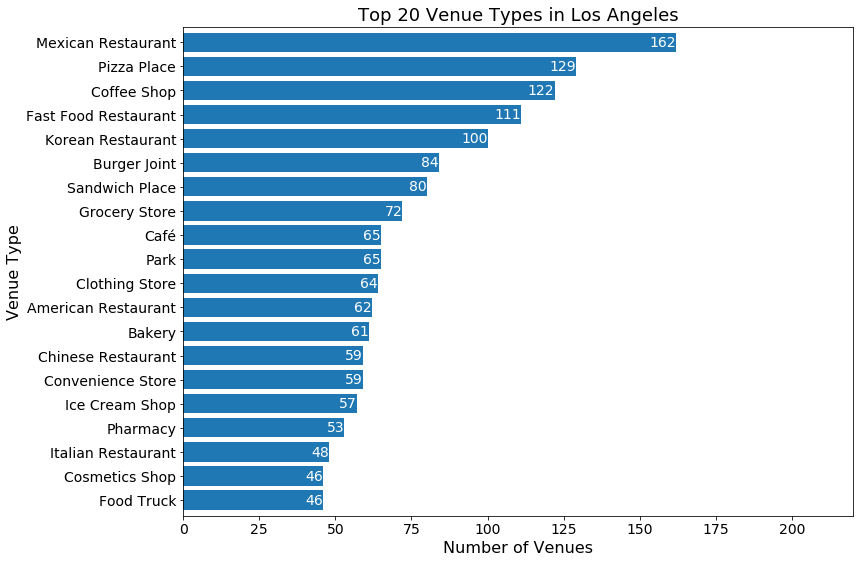

In [735]:
# Group venues by venue category
la_venues_bytype = la_venues.groupby('Venue Category').count()

# Sort the venue types by count
la_venues_bytype.sort_values(by=['Venue'],ascending=False, inplace=True)
la_venues_bytype = la_venues_bytype.reset_index()

### Plot most common venues
# Sort the venue types by count
la_top20_venues_bytype = la_venues.groupby('Venue Category').count()
la_top20_venues_bytype.sort_values(by=['Venue'],ascending=True, inplace=True)

# get the top 20 entries of the Venue Category column
la_top20_venues_bytype = la_top20_venues_bytype['Venue'].tail(20) 
#la_top20_venues_bytype = (la_top20_venues_bytype['Venue'].tail(20) * (100/la_meat_venues.shape[0])).round(2)

# Horizontal Bar Plot
la_top20_venues_bytype.plot(kind='barh', figsize=(12, 9),  width=0.8, fontsize = 14) 

plt.xlabel('Number of Venues', fontsize=16)
plt.ylabel('Venue Type', fontsize=16)
plt.title('Top 20 Venue Types in Los Angeles',fontsize=18)
# Fixed scale
plt.xlim([0, 220])

for i,Venue in enumerate(la_top20_venues_bytype):
    all_venues = la_venues.shape[0]
    plt.annotate(str(Venue), # text to display
             xy=(Venue,i),                    # start the text at end of each bar
             rotation=0,                  # horizontal orientation
             va='center',                    # centered in the middle of the bar
             ha='right',                      # text 'right' aligned.
             color='white',
             fontsize=14
            )

plt.show()


Filter out all not meat related venues and keep only those potentially serving or selling meat by filtering out venues not containing the following strings in the 'Venue Category' column: 
* Restaurant
* market or Market
* Food
* Meat
* Pizza
* Hotel
* Burger
* Diner
* Hot Dog
* Grocery
* Sandwich
* Snack
* Salad
* Taco
* BBQ
* Bodega
* Burrito


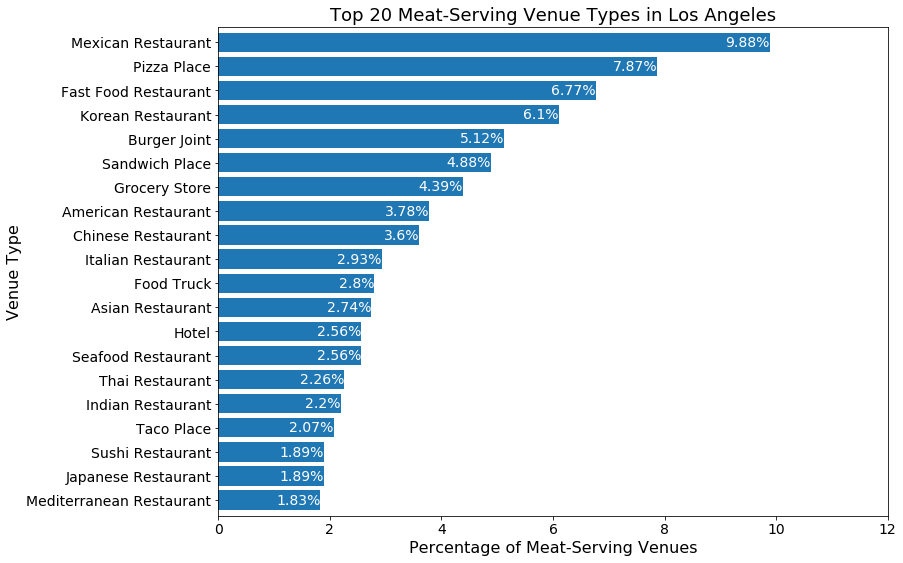

In [736]:
# New dataframe for only meat related venues
la_meat_venues = la_venues[la_venues['Venue Category'].str.contains('Restaurant|market|Market|Food|Meat|Pizza|Hotel|Burger|Diner|Hot Dog|Grocery|Sandwich|Snack|Salad|Taco|BBQ|Bodega|Burrito')]

# Group meat venues by venue category
la_meat_venues_bytype = la_meat_venues.groupby('Venue Category').count()

# Sort the meat venue types by count
la_meat_venues_bytype.sort_values(by=['Venue'],ascending=False, inplace=True)
la_meat_venues_bytype = la_meat_venues_bytype.reset_index()


### Plot most common venues
# Sort the venue types by count
la_top20_meat_venues_bytype = la_meat_venues.groupby('Venue Category').count()
la_top20_meat_venues_bytype.sort_values(by=['Venue'],ascending=True, inplace=True)


# get the top 20 entries of the Venue Category column
la_top20_meat_venues_bytype = (la_top20_meat_venues_bytype['Venue'].tail(20) * (100/la_meat_venues.shape[0])).round(2)

la_top20_meat_venues_bytype.plot(kind='barh', figsize=(12, 9),  width=0.8, fontsize = 14) 


plt.xlabel('Percentage of Meat-Serving Venues', fontsize=16)
plt.ylabel('Venue Type', fontsize=16)
plt.title('Top 20 Meat-Serving Venue Types in Los Angeles',fontsize=18)
# Fixed scale
plt.xlim([0, 12])

for i,Venue in enumerate(la_top20_meat_venues_bytype):
    plt.annotate(str(Venue)+'%', # text to display
             xy=(Venue,i),                    # start the text at end of each bar
             rotation=0,                  # horizontal orientation
             va='center',                    # centered in the middle of the bar
             ha='right',                      # text 'right' aligned.
             color='white',
             fontsize=14
            )

plt.show()

Group venues by neighborhood

In [737]:
#  Group venues by neighborhood
la_venues_grouped = la_venues.groupby('Neighborhood').count()
print('Number of neighborhoods with venues in LA: ' + str(la_venues_grouped.shape[0]))

# Sort neighborhoods by number of venues
la_venues_grouped.sort_values(by=['Venue'],ascending=False, inplace=True)
la_venues_grouped = la_venues_grouped.reset_index()

la_venues_grouped[['Neighborhood','Venue']].head(20)

Number of neighborhoods with venues in LA: 85


,Neighborhood,Venue
0,"Long Beach, Long Beach (AARP Pharmacy), Long B...",100
1,Western Wilton (Los Angeles),100
2,Fairfax (Los Angeles),100
3,Griffith Park (Los Angeles),100
4,Koreatown (Los Angeles),100
5,Westwood (Los Angeles),100
6,"Manhattan Beach, Manhattan Beach (PO Boxes)",91
7,Echo Park (Los Angeles),91
8,Century City (Los Angeles),89
9,"Belmont Shore (Long Beach), Belmont Shore (PO ...",88


Display some statistics on the returned venues:

In [738]:
# Some analysis of the returned venues 
print("\033[1m" + "\n LOS ANGELES VENUES" + "\033[0m")

print("\n Number of venues in LA: " + str(la_venues.shape[0]))

print("\n Avg. number of venues in LA per neighborhood: " + str(la_venues.shape[0]/la_neighborhoods.shape[0]))

# Most common venue types
print("\n Number of venue types in LA: " + str(la_venues_bytype.shape[0]))

print("\n The five moost common venues in LA are: \n 1- " 
      + la_venues_bytype.loc[la_venues_bytype.index[0], 'Venue Category']  + "\t ... "  + str(la_venues_bytype.loc[la_venues_bytype.index[0], 'Venue']) + ' (' + str((la_venues_bytype.loc[la_venues_bytype.index[0], 'Venue'] * (100/la_venues.shape[0])).round(2)) + '%)' + "\n 2- "
      + la_venues_bytype.loc[la_venues_bytype.index[1], 'Venue Category']  + "\t ... "  + str(la_venues_bytype.loc[la_venues_bytype.index[1], 'Venue']) + ' (' + str((la_venues_bytype.loc[la_venues_bytype.index[1], 'Venue'] * (100/la_venues.shape[0])).round(2)) + '%)' + "\n 3- "
      + la_venues_bytype.loc[la_venues_bytype.index[2], 'Venue Category']  + "\t ... "  + str(la_venues_bytype.loc[la_venues_bytype.index[2], 'Venue']) + ' (' + str((la_venues_bytype.loc[la_venues_bytype.index[2], 'Venue'] * (100/la_venues.shape[0])).round(2)) + '%)' + "\n 4- "
      + la_venues_bytype.loc[la_venues_bytype.index[3], 'Venue Category']  + "\t ... "  + str(la_venues_bytype.loc[la_venues_bytype.index[3], 'Venue']) + ' (' + str((la_venues_bytype.loc[la_venues_bytype.index[3], 'Venue'] * (100/la_venues.shape[0])).round(2)) + '%)' + "\n 5- "
      + la_venues_bytype.loc[la_venues_bytype.index[4], 'Venue Category']  + "\t ... "  + str(la_venues_bytype.loc[la_venues_bytype.index[4], 'Venue']) + ' (' + str((la_venues_bytype.loc[la_venues_bytype.index[4], 'Venue'] * (100/la_venues.shape[0])).round(2)) + '%)')


 LOS ANGELES VENUES

 Number of venues in LA: 3677

 Avg. number of venues in LA per neighborhood: 42.75581395348837

 Number of venue types in LA: 321

 The five moost common venues in LA are: 
 1- Mexican Restaurant	 ... 162 (4.41%)
 2- Pizza Place	 ... 129 (3.51%)
 3- Coffee Shop	 ... 122 (3.32%)
 4- Fast Food Restaurant	 ... 111 (3.02%)
 5- Korean Restaurant	 ... 100 (2.72%)


Group meat-serving venues by neighborhood

In [739]:
# Group food venues by neighborhood
la_meat_venues_grouped = la_meat_venues.groupby('Neighborhood').count()
print('Number of neighborhoods with meat-serving venues in LA: ' + str(la_meat_venues_grouped.shape[0]))

# Sort neighborhoods by number of venues
la_meat_venues_grouped.sort_values(by=['Venue'],ascending=False, inplace=True)
la_meat_venues_grouped = la_meat_venues_grouped.reset_index()

la_meat_venues_grouped[['Neighborhood','Venue']].head(20)

Number of neighborhoods with meat-serving venues in LA: 80


,Neighborhood,Venue
0,Western Wilton (Los Angeles),63
1,Koreatown (Los Angeles),60
2,"Artesia, Artesia (PO Boxes)",58
3,Westwood (Los Angeles),47
4,Byzantine-Latino Quarter (Los Angeles),44
5,Century City (Los Angeles),43
6,Echo Park (Los Angeles),43
7,"Long Beach, Long Beach (AARP Pharmacy), Long B...",43
8,"Lawndale, Lawndale Federal Bldg",39
9,Griffith Park (Los Angeles),37


Some general results about meat-serving venues in LA

In [740]:
# Some analysis of the returned venues 
print("\033[1m" + "\n LOS ANGELES VENUES" + "\033[0m")

print("\n Number of meat-serving venues in LA: " + str(la_meat_venues.shape[0]))

print("\n Avg. number of meat-serving in LA per neighborhood: " + str(la_meat_venues.shape[0]/la_neighborhoods.shape[0]))

# Most common venue types
print("\n Number of meat-serving types in LA: " + str(la_meat_venues_bytype.shape[0]))

print("\n The five most common meat-serving venues in LA are: \n 1- " 
      + la_meat_venues_bytype.loc[la_meat_venues_bytype.index[0], 'Venue Category']  + "\t ... "  + str(la_meat_venues_bytype.loc[la_meat_venues_bytype.index[0], 'Venue']) + ' (' + str((la_meat_venues_bytype.loc[la_meat_venues_bytype.index[0], 'Venue'] * (100/la_meat_venues.shape[0])).round(2)) + '%)' + "\n 2- "
      + la_meat_venues_bytype.loc[la_meat_venues_bytype.index[1], 'Venue Category']  + "\t ... "  + str(la_meat_venues_bytype.loc[la_meat_venues_bytype.index[1], 'Venue']) + ' (' + str((la_meat_venues_bytype.loc[la_meat_venues_bytype.index[1], 'Venue'] * (100/la_meat_venues.shape[0])).round(2)) + '%)' + "\n 3- "
      + la_meat_venues_bytype.loc[la_meat_venues_bytype.index[2], 'Venue Category']  + "\t ... "  + str(la_meat_venues_bytype.loc[la_meat_venues_bytype.index[2], 'Venue']) + ' (' + str((la_meat_venues_bytype.loc[la_meat_venues_bytype.index[2], 'Venue'] * (100/la_meat_venues.shape[0])).round(2)) + '%)' + "\n 4- "
      + la_meat_venues_bytype.loc[la_meat_venues_bytype.index[3], 'Venue Category']  + "\t ... "  + str(la_meat_venues_bytype.loc[la_meat_venues_bytype.index[3], 'Venue']) + ' (' + str((la_meat_venues_bytype.loc[la_meat_venues_bytype.index[3], 'Venue'] * (100/la_meat_venues.shape[0])).round(2)) + '%)' + "\n 5- "
      + la_meat_venues_bytype.loc[la_meat_venues_bytype.index[4], 'Venue Category']  + "\t ... "  + str(la_meat_venues_bytype.loc[la_meat_venues_bytype.index[4], 'Venue']) + ' (' + str((la_meat_venues_bytype.loc[la_meat_venues_bytype.index[4], 'Venue'] * (100/la_meat_venues.shape[0])).round(2)) + '%)')

# Venue types by neighborhood
print("\n \n Number of neighborhoods in LA: " + str(la_neighborhoods.shape[0]))
print("\n Number of neighborhoods with at least one venue in LA: " + str(la_venues_grouped.shape[0]))
print("\n Number of neighborhoods with at least one meat-serving venue in LA: " + str(la_meat_venues_grouped.shape[0]))

print("\n\n Maximum number of meat-serving venues per neighborhood in LA: " + str(la_meat_venues_grouped.loc[la_venues_grouped.index[0], 'Venue Category']))

print("\n The five neighborhoods with the most meat-serving venues in LA are: \n 1- " 
      + la_meat_venues_grouped.loc[la_meat_venues_grouped.index[0], 'Neighborhood']  + "\t ... "  + str(la_meat_venues_grouped.loc[la_meat_venues_grouped.index[0], 'Venue'])  + "\n 2- "
      + la_meat_venues_grouped.loc[la_meat_venues_grouped.index[1], 'Neighborhood']  + "\t ... "  + str(la_meat_venues_grouped.loc[la_meat_venues_grouped.index[1], 'Venue'])  + "\n 3- "
      + la_meat_venues_grouped.loc[la_meat_venues_grouped.index[2], 'Neighborhood']  + "\t ... "  + str(la_meat_venues_grouped.loc[la_meat_venues_grouped.index[2], 'Venue'])  + "\n 4- "
      + la_meat_venues_grouped.loc[la_meat_venues_grouped.index[3], 'Neighborhood']  + "\t ... "  + str(la_meat_venues_grouped.loc[la_meat_venues_grouped.index[3], 'Venue'])  + "\n 5- "
      + la_meat_venues_grouped.loc[la_meat_venues_grouped.index[4], 'Neighborhood']  + "\t ... "  + str(la_meat_venues_grouped.loc[la_meat_venues_grouped.index[4], 'Venue']))


 LOS ANGELES VENUES

 Number of meat-serving venues in LA: 1640

 Avg. number of meat-serving in LA per neighborhood: 19.069767441860463

 Number of meat-serving types in LA: 79

 The five most common meat-serving venues in LA are: 
 1- Mexican Restaurant	 ... 162 (9.88%)
 2- Pizza Place	 ... 129 (7.87%)
 3- Fast Food Restaurant	 ... 111 (6.77%)
 4- Korean Restaurant	 ... 100 (6.1%)
 5- Burger Joint	 ... 84 (5.12%)

 
 Number of neighborhoods in LA: 86

 Number of neighborhoods with at least one venue in LA: 85

 Number of neighborhoods with at least one meat-serving venue in LA: 80


 Maximum number of meat-serving venues per neighborhood in LA: 63

 The five neighborhoods with the most meat-serving venues in LA are: 
 1- Western Wilton (Los Angeles)	 ... 63
 2- Koreatown (Los Angeles)	 ... 60
 3- Artesia, Artesia (PO Boxes)	 ... 58
 4- Westwood (Los Angeles)	 ... 47
 5- Byzantine-Latino Quarter (Los Angeles)	 ... 44


Prepare top 10 neighborhoods with most food venues for plotting

In [741]:
# Sort the venue types by count
la_top10_meat_venues_grouped = la_meat_venues.groupby('Neighborhood').count()
la_top10_meat_venues_grouped.sort_values(by=['Venue'],ascending=False, inplace=True)
la_top10_meat_venues_grouped=la_top10_meat_venues_grouped.reset_index()

# get the top 20 entries of the Venue Category column
la_top10_meat_venues_grouped_with_coords = la_top10_meat_venues_grouped[['Neighborhood','Venue']].head(10)
# add neighborhood coordinates
la_top10_meat_venues_grouped_with_coords = pd.merge(la_neighborhoods, la_top10_meat_venues_grouped_with_coords, on='Neighborhood')

Plot neighborhoods as markers on map and highlight the top tenneighborhoods containing the most number of meat-serving venues. 

In [742]:
# Get city coordinates
la_address = 'Los Angeles, CA, USA'

geolocator = Nominatim()

la_location = geolocator.geocode(la_address)
la_latitude = la_location.latitude
la_longitude = la_location.longitude
print('The geograpical coordinate of Los Angeles are {}, {}.'.format(la_latitude, la_longitude))

# Create map using Folium library and city's latitude and longitude values
la_map = folium.Map(location=[la_latitude, la_longitude], zoom_start=10,control_scale = True)

# Add markers to map
for lat, lng, zipcode, neighborhood in zip(la_neighborhoods['Latitude'], la_neighborhoods['Longitude'], la_neighborhoods['Zip Code'], la_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(la_map)  
    
# Top 10 neighborhoods with most food venues
for lat, lng, zipcode, neighborhood in zip(la_top10_meat_venues_grouped_with_coords['Latitude'], la_top10_meat_venues_grouped_with_coords['Longitude'], la_top10_meat_venues_grouped_with_coords['Zip Code'], la_top10_meat_venues_grouped_with_coords['Neighborhood']):
    label = '{}, {}'.format(neighborhood, zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='pink',
        fill_opacity=0.8,
        parse_html=False).add_to(la_map)  
    
la_map

C:\Users\JAIONEAzpiroz\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


The geograpical coordinate of Los Angeles are 34.0536834, -118.2427669.


We now repeat the venue extraction process on both San Francisco and New York City.

### San Francisco (Part 3) - Venues

In [743]:
# Extract venues
sf_venues = getNearbyVenues(names=sf_neighborhoods['Neighborhood'],
                                   latitudes=sf_neighborhoods['Latitude'],
                                   longitudes=sf_neighborhoods['Longitude'], 
                                   radius = 500
                                  )

In [744]:
# Group venues by venue category
sf_venues_bytype = sf_venues.groupby('Venue Category').count()

# Sort the venue types by count
sf_venues_bytype.sort_values(by=['Venue'],ascending=False, inplace=True)
sf_venues_bytype = sf_venues_bytype.reset_index()

# Show first few rows of venues dataframe
sf_venues[['Venue','Venue Latitude','Venue Longitude','Venue Category']].head(10)

,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Asian Art Museum,37.780178,-122.416505,Art Museum
1,Louise M. Davies Symphony Hall,37.777976,-122.420157,Concert Hall
2,Herbst Theater,37.779548,-122.420953,Concert Hall
3,Philz Coffee,37.781433,-122.417073,Coffee Shop
4,War Memorial Opera House,37.778601,-122.420816,Opera House
5,San Francisco Ballet,37.778580,-122.420798,Dance Studio
6,Ananda Fuara,37.777693,-122.416353,Vegetarian / Vegan Restaurant
7,Off the Grid: Civic Center,37.779303,-122.418160,Street Food Gathering
8,Siam Orchid Traditional Thai Massage,37.777111,-122.417967,Massage Studio
9,August 1 Five,37.780537,-122.420188,Indian Restaurant


Group venues by venue type and plot the 20 most common venues

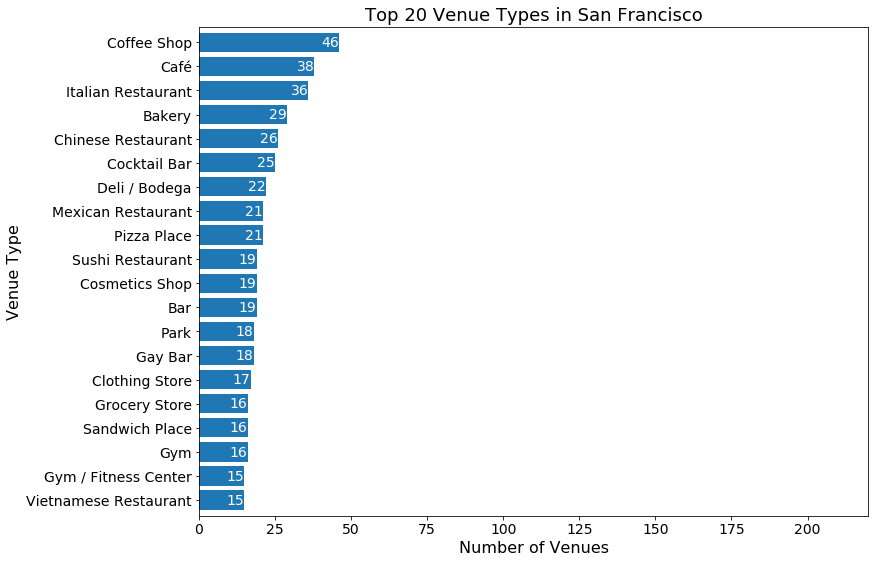

In [745]:
# Group venues by venue category
sf_venues_bytype = sf_venues.groupby('Venue Category').count()

# Sort the venue types by count
sf_venues_bytype.sort_values(by=['Venue'],ascending=False, inplace=True)
sf_venues_bytype = sf_venues_bytype.reset_index()

### Plot most common venues
# Sort the venue types by count
sf_top20_venues_bytype = sf_venues.groupby('Venue Category').count()
sf_top20_venues_bytype.sort_values(by=['Venue'],ascending=True, inplace=True)

# get the top 20 entries of the Venue Category column
sf_top20_venues_bytype = sf_top20_venues_bytype['Venue'].tail(20)

# Horizontal Bar Plot
sf_top20_venues_bytype.plot(kind='barh', figsize=(12, 9),  width=0.8, fontsize = 14) 

plt.xlabel('Number of Venues', fontsize=16)
plt.ylabel('Venue Type', fontsize=16)
plt.title('Top 20 Venue Types in San Francisco',fontsize=18)
# Fixed scale
plt.xlim([0, 220])

for i,Venue in enumerate(sf_top20_venues_bytype):
    plt.annotate(str(Venue), # text to display
             xy=(Venue,i),                    # start the text at end of each bar
             rotation=0,                  # horizontal orientation
             va='center',                    # centered in the middle of the bar
             ha='right',                      # text 'right' aligned.
             color='white',
             fontsize=14
            )

plt.show()


Filter out all not food related venues and keep only those serving or selling food

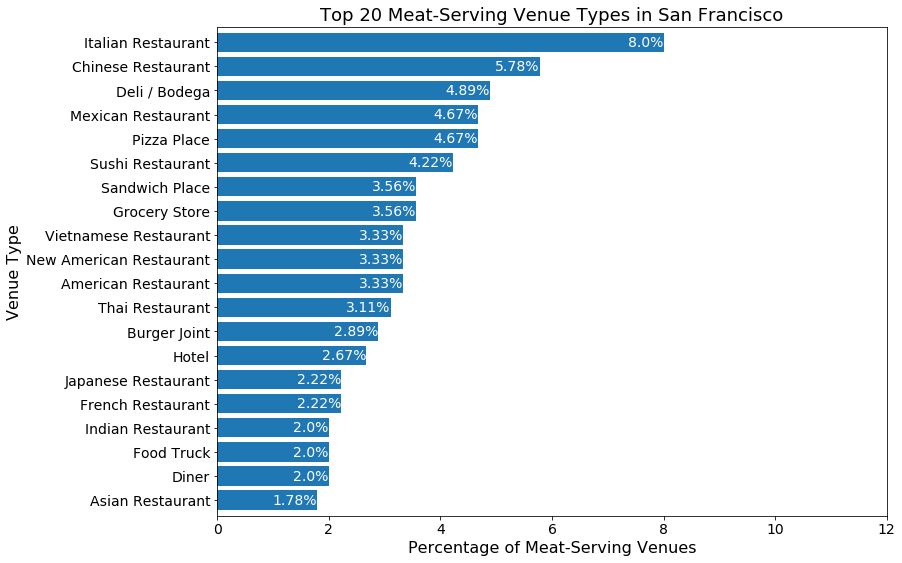

In [746]:
# New dataframe for only food related venues
sf_meat_venues = sf_venues[sf_venues['Venue Category'].str.contains('Restaurant|market|Market|Food|Pizza|Hotel|Burger|Diner|Hot Dog|Grocery|Sandwich|Snack|Salad|Taco|BBQ|Bodega|Burrito')]

# Group food venues by venue category
sf_meat_venues_bytype = sf_meat_venues.groupby('Venue Category').count()

# Sort the food venue types by count
sf_meat_venues_bytype.sort_values(by=['Venue'],ascending=False, inplace=True)
sf_meat_venues_bytype = sf_meat_venues_bytype.reset_index()


### Plot most common venues
# Sort the venue types by count
sf_top20_meat_venues_bytype = sf_meat_venues.groupby('Venue Category').count()
sf_top20_meat_venues_bytype.sort_values(by=['Venue'],ascending=True, inplace=True)


# get the top 20 entries of the Venue Category column
#sf_top20_meat_venues_bytype = sf_top20_meat_venues_bytype['Venue'].tail(20)
sf_top20_meat_venues_bytype = (sf_top20_meat_venues_bytype['Venue'].tail(20) * (100/sf_meat_venues.shape[0])).round(2)

sf_top20_meat_venues_bytype.plot(kind='barh', figsize=(12, 9),  width=0.8, fontsize = 14) 


plt.xlabel('Percentage of Meat-Serving Venues', fontsize=16)
plt.ylabel('Venue Type', fontsize=16)
plt.title('Top 20 Meat-Serving Venue Types in San Francisco',fontsize=18)
# Fixed scale
plt.xlim([0, 12])

for i,Venue in enumerate(sf_top20_meat_venues_bytype):
    plt.annotate(str(Venue)+'%', # text to display
             xy=(Venue,i),                    # start the text at end of each bar
             rotation=0,                  # horizontal orientation
             va='center',                    # centered in the middle of the bar
             ha='right',                      # text 'right' aligned.
             color='white',
             fontsize=14
            )

plt.show()

Group venues by neighborhood

In [747]:
#  Group venues by neighborhood
sf_venues_grouped = sf_venues.groupby('Neighborhood').count()
print('Number of neighborhoods with venues in SF: ' + str(sf_venues_grouped.shape[0]))

# Sort neighborhoods by number of venues
sf_venues_grouped.sort_values(by=['Venue'],ascending=False, inplace=True)
sf_venues_grouped = sf_venues_grouped.reset_index()

sf_venues_grouped[['Neighborhood','Venue']].head(20)

Number of neighborhoods with venues in SF: 21


,Neighborhood,Venue
0,North Beach/Chinatown,100
1,Inner Mission/Bernal Heights,100
2,South of Market,100
3,Potrero Hill,100
4,Polk/Russian Hill (Nob Hill),100
5,Castro/Noe Valley,100
6,Western Addition/Japantown,100
7,Hayes Valley/Tenderloin/North of Market,100
8,Chinatown,100
9,Marina,67


In [748]:
# Some analysis of the returned venues 
print("\033[1m" + "\n SAN FRANCISCO" + "\033[0m")

print("\n Number of venues in SF: " + str(sf_venues.shape[0]))

print("\n Avg. number of venues in SF per neighborhood: " + str(sf_venues.shape[0]/sf_neighborhoods.shape[0]))

# Most common venue types
print("\n Number of venue types in SF: " + str(sf_venues_bytype.shape[0]))

print("\n The five most common venues in SF are: \n 1- " 
      + sf_venues_bytype.loc[sf_venues_bytype.index[0], 'Venue Category']  + "\t ... "  + str(sf_venues_bytype.loc[sf_venues_bytype.index[0], 'Venue']) + ' (' + str((sf_venues_bytype.loc[la_venues_bytype.index[0], 'Venue'] * (100/sf_venues.shape[0])).round(2)) + '%)' + "\n 2- "
      + sf_venues_bytype.loc[sf_venues_bytype.index[1], 'Venue Category']  + "\t ... "  + str(sf_venues_bytype.loc[sf_venues_bytype.index[1], 'Venue']) + ' (' + str((sf_venues_bytype.loc[la_venues_bytype.index[1], 'Venue'] * (100/sf_venues.shape[0])).round(2)) + '%)' + "\n 3- "
      + sf_venues_bytype.loc[sf_venues_bytype.index[2], 'Venue Category']  + "\t ... "  + str(sf_venues_bytype.loc[sf_venues_bytype.index[2], 'Venue']) + ' (' + str((sf_venues_bytype.loc[la_venues_bytype.index[2], 'Venue'] * (100/sf_venues.shape[0])).round(2)) + '%)' + "\n 4- "
      + sf_venues_bytype.loc[sf_venues_bytype.index[3], 'Venue Category']  + "\t ... "  + str(sf_venues_bytype.loc[sf_venues_bytype.index[3], 'Venue']) + ' (' + str((sf_venues_bytype.loc[la_venues_bytype.index[3], 'Venue'] * (100/sf_venues.shape[0])).round(2)) + '%)' + "\n 5- "
      + sf_venues_bytype.loc[sf_venues_bytype.index[4], 'Venue Category']  + "\t ... "  + str(sf_venues_bytype.loc[sf_venues_bytype.index[4], 'Venue']) + ' (' + str((sf_venues_bytype.loc[la_venues_bytype.index[4], 'Venue'] * (100/sf_venues.shape[0])).round(2)) + '%)')


 SAN FRANCISCO

 Number of venues in SF: 1248

 Avg. number of venues in SF per neighborhood: 59.42857142857143

 Number of venue types in SF: 250

 The five most common venues in SF are: 
 1- Coffee Shop	 ... 46 (3.69%)
 2- Café	 ... 38 (3.04%)
 3- Italian Restaurant	 ... 36 (2.88%)
 4- Bakery	 ... 29 (2.32%)
 5- Chinese Restaurant	 ... 26 (2.08%)


Group meat-serving venues by neighborhood

In [749]:
# Group food venues by neighborhood
sf_meat_venues_grouped = sf_meat_venues.groupby('Neighborhood').count()
print('Number of neighborhoods with meat-serving venues in SF: ' + str(sf_meat_venues_grouped.shape[0]))

# Sort neighborhoods by number of venues
sf_meat_venues_grouped.sort_values(by=['Venue'],ascending=False, inplace=True)
sf_meat_venues_grouped = sf_meat_venues_grouped.reset_index()

sf_meat_venues_grouped[['Neighborhood','Venue']].head(20)

Number of neighborhoods with meat-serving venues in SF: 19


,Neighborhood,Venue
0,North Beach/Chinatown,50
1,Inner Mission/Bernal Heights,48
2,Potrero Hill,47
3,Hayes Valley/Tenderloin/North of Market,38
4,Chinatown,32
5,Western Addition/Japantown,31
6,Polk/Russian Hill (Nob Hill),31
7,Castro/Noe Valley,29
8,South of Market,23
9,St. Francis Wood/Miraloma/West Portal,22


Some general results about meat-serving venues in San Francisco

In [750]:
# Some analysis of the returned venues 
print("\033[1m" + "\n SAN FRANCISCO VENUES" + "\033[0m")

print("\n Number of meat-serving venues in SF: " + str(sf_meat_venues.shape[0]))

print("\n Avg. number of meat-serving venues in SF per neighborhood: " + str(sf_meat_venues.shape[0]/sf_neighborhoods.shape[0]))

# Most common venue types
print("\n Number of meat-serving venue types in SF: " + str(sf_meat_venues_bytype.shape[0]))

print("\n The five most common meat-serving venues in SF are: \n 1- " 
      + sf_meat_venues_bytype.loc[sf_meat_venues_bytype.index[0], 'Venue Category']  + "\t ... "  + str(sf_meat_venues_bytype.loc[sf_meat_venues_bytype.index[0], 'Venue']) + ' (' + str((sf_meat_venues_bytype.loc[sf_meat_venues_bytype.index[0], 'Venue'] * (100/sf_meat_venues.shape[0])).round(2)) + '%)' + "\n 2- "
      + sf_meat_venues_bytype.loc[sf_meat_venues_bytype.index[1], 'Venue Category']  + "\t ... "  + str(sf_meat_venues_bytype.loc[sf_meat_venues_bytype.index[1], 'Venue']) + ' (' + str((sf_meat_venues_bytype.loc[sf_meat_venues_bytype.index[1], 'Venue'] * (100/sf_meat_venues.shape[0])).round(2)) + '%)' + "\n 3- "
      + sf_meat_venues_bytype.loc[sf_meat_venues_bytype.index[2], 'Venue Category']  + "\t ... "  + str(sf_meat_venues_bytype.loc[sf_meat_venues_bytype.index[2], 'Venue']) + ' (' + str((sf_meat_venues_bytype.loc[sf_meat_venues_bytype.index[2], 'Venue'] * (100/sf_meat_venues.shape[0])).round(2)) + '%)' + "\n 4- "
      + sf_meat_venues_bytype.loc[sf_meat_venues_bytype.index[3], 'Venue Category']  + "\t ... "  + str(sf_meat_venues_bytype.loc[sf_meat_venues_bytype.index[3], 'Venue']) + ' (' + str((sf_meat_venues_bytype.loc[sf_meat_venues_bytype.index[3], 'Venue'] * (100/sf_meat_venues.shape[0])).round(2)) + '%)' + "\n 5- "
      + sf_meat_venues_bytype.loc[sf_meat_venues_bytype.index[4], 'Venue Category']  + "\t ... "  + str(sf_meat_venues_bytype.loc[sf_meat_venues_bytype.index[4], 'Venue']) + ' (' + str((sf_meat_venues_bytype.loc[sf_meat_venues_bytype.index[4], 'Venue'] * (100/sf_meat_venues.shape[0])).round(2)) + '%)')


# Venue types by neighborhood
print("\n \n Number of neighborhoods in SF: " + str(sf_neighborhoods.shape[0]))
print("\n Number of neighborhoods with at least one venue in SF: " + str(sf_venues_grouped.shape[0]))
print("\n Number of neighborhoods with at least one meat-serving venue in SF: " + str(sf_meat_venues_grouped.shape[0]))

print("\n Maximum number of meat-serving venues per neighborhood in SF: " + str(sf_meat_venues_grouped.loc[sf_meat_venues_grouped.index[0], 'Venue Category']))

print("\n The five neighborhoods with the most meat-serving venues in SF are: \n 1- " 
      + sf_meat_venues_grouped.loc[sf_meat_venues_grouped.index[0], 'Neighborhood']  + "\t ... "  + str(sf_meat_venues_grouped.loc[sf_meat_venues_grouped.index[0], 'Venue'])  + "\n 2- "
      + sf_meat_venues_grouped.loc[sf_meat_venues_grouped.index[1], 'Neighborhood']  + "\t ... "  + str(sf_meat_venues_grouped.loc[sf_meat_venues_grouped.index[1], 'Venue'])  + "\n 3- "
      + sf_meat_venues_grouped.loc[sf_meat_venues_grouped.index[2], 'Neighborhood']  + "\t ... "  + str(sf_meat_venues_grouped.loc[sf_meat_venues_grouped.index[2], 'Venue'])  + "\n 4- "
      + sf_meat_venues_grouped.loc[sf_meat_venues_grouped.index[3], 'Neighborhood']  + "\t ... "  + str(sf_meat_venues_grouped.loc[sf_meat_venues_grouped.index[3], 'Venue'])  + "\n 5- "
      + sf_meat_venues_grouped.loc[sf_meat_venues_grouped.index[4], 'Neighborhood']  + "\t ... "  + str(sf_meat_venues_grouped.loc[sf_meat_venues_grouped.index[5], 'Venue']))


 SAN FRANCISCO VENUES

 Number of meat-serving venues in SF: 450

 Avg. number of meat-serving venues in SF per neighborhood: 21.428571428571427

 Number of meat-serving venue types in SF: 77

 The five most common meat-serving venues in SF are: 
 1- Italian Restaurant	 ... 36 (8.0%)
 2- Chinese Restaurant	 ... 26 (5.78%)
 3- Deli / Bodega	 ... 22 (4.89%)
 4- Pizza Place	 ... 21 (4.67%)
 5- Mexican Restaurant	 ... 21 (4.67%)

 
 Number of neighborhoods in SF: 21

 Number of neighborhoods with at least one venue in SF: 21

 Number of neighborhoods with at least one meat-serving venue in SF: 19

 Maximum number of meat-serving venues per neighborhood in SF: 50

 The five neighborhoods with the most meat-serving venues in SF are: 
 1- North Beach/Chinatown	 ... 50
 2- Inner Mission/Bernal Heights	 ... 48
 3- Potrero Hill	 ... 47
 4- Hayes Valley/Tenderloin/North of Market	 ... 38
 5- Chinatown	 ... 31


Prepare top 10 neighborhoods with most meat-serving venues for plotting

In [751]:
# Sort the venue types by count
sf_top10_meat_venues_grouped = sf_meat_venues.groupby('Neighborhood').count()
sf_top10_meat_venues_grouped.sort_values(by=['Venue'],ascending=False, inplace=True)
sf_top10_meat_venues_grouped=sf_top10_meat_venues_grouped.reset_index()

# get the top 20 entries of the Venue Category column
sf_top10_meat_venues_grouped_with_coords = sf_top10_meat_venues_grouped[['Neighborhood','Venue']].head(10)
# add neighborhood coordinates
sf_top10_meat_venues_grouped_with_coords = pd.merge(sf_neighborhoods, sf_top10_meat_venues_grouped_with_coords, on='Neighborhood')


In [753]:
# Get city coordinates
sf_address = 'San Francisco, CA, USA'

geolocator = Nominatim()

sf_location = geolocator.geocode(sf_address)
sf_latitude = sf_location.latitude
sf_longitude = sf_location.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(sf_latitude, sf_longitude))

# Create map using Folium library and city's latitude and longitude values
sf_map = folium.Map(location=[sf_latitude, sf_longitude], zoom_start=12,control_scale = True)

# Add markers to map
for lat, lng, zipcode, neighborhood in zip(sf_neighborhoods['Latitude'], sf_neighborhoods['Longitude'], sf_neighborhoods['Zip Code'], sf_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(sf_map)  
    
# Top 10 neighborhoods with most food venues
for lat, lng, zipcode, neighborhood in zip(sf_top10_meat_venues_grouped_with_coords['Latitude'], sf_top10_meat_venues_grouped_with_coords['Longitude'], sf_top10_meat_venues_grouped_with_coords['Zip Code'], sf_top10_meat_venues_grouped_with_coords['Neighborhood']):
    label = '{}, {}'.format(neighborhood, zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='pink',
        fill_opacity=0.8,
        parse_html=False).add_to(sf_map)  
    
sf_map

C:\Users\JAIONEAzpiroz\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


The geograpical coordinate of San Francisco are 37.7792808, -122.4192363.


### New York (Part 3) - Venues

In [772]:
# Extract venues
ny_venues = getNearbyVenues(names=ny_neighborhoods['Neighborhood'],
                                   latitudes=ny_neighborhoods['Latitude'],
                                   longitudes=ny_neighborhoods['Longitude'],
                                   radius=550
                                  )

In [773]:
# Group venues by venue category
ny_venues_bytype = ny_venues.groupby('Venue Category').count()

# Sort the venue types by count
ny_venues_bytype.sort_values(by=['Venue'],ascending=False, inplace=True)
ny_venues_bytype = ny_venues_bytype.reset_index()

ny_venues[['Venue','Venue Latitude','Venue Longitude','Venue Category']].head(10)

,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Liberato,40.853744,-73.907966,Latin American Restaurant
1,Accra Resturant,40.853871,-73.908421,African Restaurant
2,My Pizza,40.849670,-73.916817,Pizza Place
3,Dunkin Donuts,40.847559,-73.912464,Donut Shop
4,Wingstop,40.854093,-73.907899,Wings Joint
5,Bravo Supermarkets,40.853936,-73.914144,Grocery Store
6,Papa John's Pizza,40.852429,-73.908976,Pizza Place
7,Chase Bank,40.854087,-73.907631,Bank
8,Food Dynasty,40.853772,-73.909267,Supermarket
9,Dunkin Donuts,40.853817,-73.908724,Donut Shop


Group venues by venue type and plot the 20 most common venues

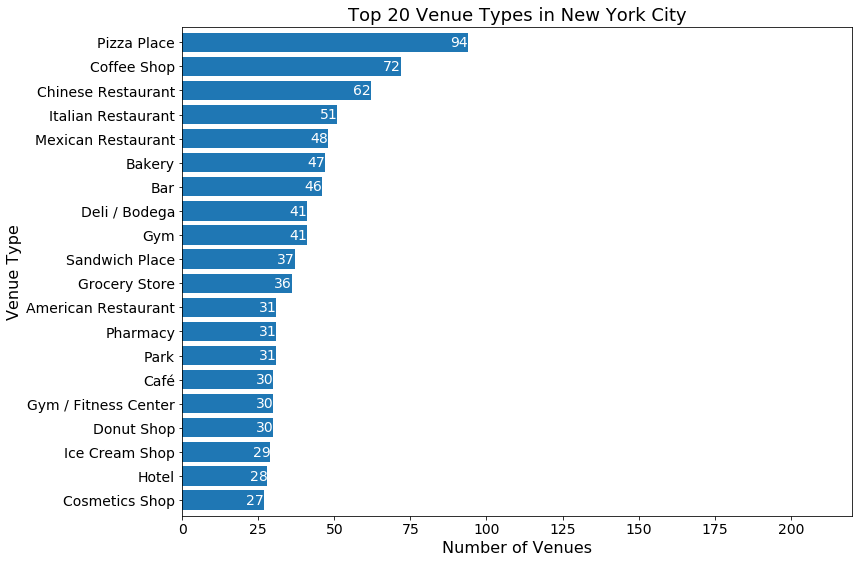

In [774]:
# Group venues by venue category
ny_venues_bytype = ny_venues.groupby('Venue Category').count()

# Sort the venue types by count
ny_venues_bytype.sort_values(by=['Venue'],ascending=False, inplace=True)
ny_venues_bytype = ny_venues_bytype.reset_index()

### Plot most common venues
# Sort the venue types by count
ny_top20_venues_bytype = ny_venues.groupby('Venue Category').count()
ny_top20_venues_bytype.sort_values(by=['Venue'],ascending=True, inplace=True)

# get the top 20 entries of the Venue Category column
ny_top20_venues_bytype = ny_top20_venues_bytype['Venue'].tail(20)

# Horizontal Bar Plot
ny_top20_venues_bytype.plot(kind='barh', figsize=(12, 9),  width=0.8, fontsize = 14) 

plt.xlabel('Number of Venues', fontsize=16)
plt.ylabel('Venue Type', fontsize=16)
plt.title('Top 20 Venue Types in New York City',fontsize=18)
# Fixed scale
plt.xlim([0, 220])


for i,Venue in enumerate(ny_top20_venues_bytype):
    plt.annotate(str(Venue), # text to display
             xy=(Venue,i),                    # start the text at end of each bar
             rotation=0,                  # horizontal orientation
             va='center',                    # centered in the middle of the bar
             ha='right',                      # text 'right' aligned.
             color='white',
             fontsize=14
            )

plt.show()


Filter out all not meat-serving related venues and keep only those serving or selling food

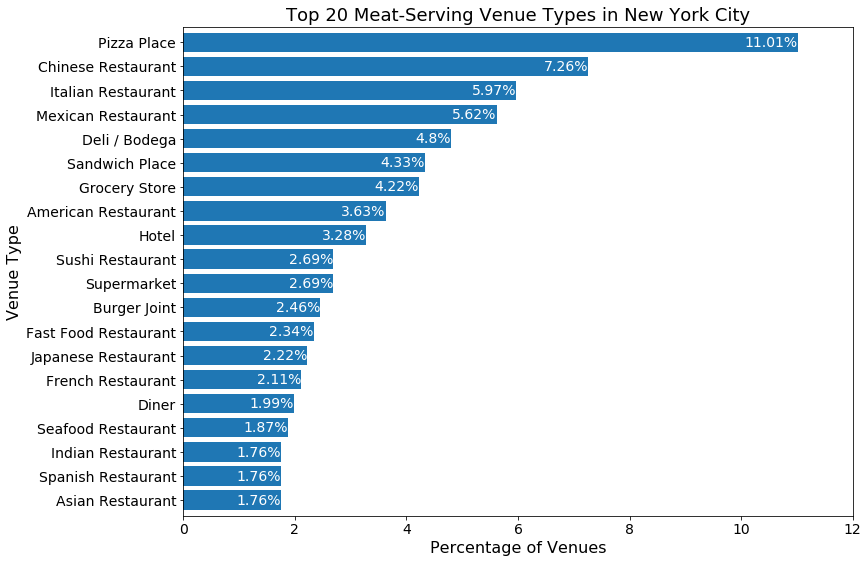

In [775]:
# New dataframe for only food related venues
ny_meat_venues = ny_venues[ny_venues['Venue Category'].str.contains('Restaurant|market|Market|Food|Pizza|Hotel|Burger|Diner|Hot Dog|Grocery|Sandwich|Snack|Salad|Taco|BBQ|Bodega|Burrito')]

# Group food venues by venue category
ny_meat_venues_bytype = ny_meat_venues.groupby('Venue Category').count()

# Sort the food venue types by count
ny_meat_venues_bytype.sort_values(by=['Venue'],ascending=False, inplace=True)
ny_meat_venues_bytype = ny_meat_venues_bytype.reset_index()


### Plot most common venues
# Sort the venue types by count
ny_top20_meat_venues_bytype = ny_meat_venues.groupby('Venue Category').count()
ny_top20_meat_venues_bytype.sort_values(by=['Venue'],ascending=True, inplace=True)


# get the top 20 entries of the Venue Category column
#ny_top20_meat_venues_bytype = ny_top20_meat_venues_bytype['Venue'].tail(20)
ny_top20_meat_venues_bytype = (ny_top20_meat_venues_bytype['Venue'].tail(20) * (100/ny_meat_venues.shape[0])).round(2)

ny_top20_meat_venues_bytype.plot(kind='barh', figsize=(12, 9),  width=0.8, fontsize = 14) 


plt.xlabel('Percentage of Venues', fontsize=16)
plt.ylabel('Venue Type', fontsize=16)
plt.title('Top 20 Meat-Serving Venue Types in New York City',fontsize=18)
# Fixed scale
plt.xlim([0, 12])

for i,Venue in enumerate(ny_top20_meat_venues_bytype):
    plt.annotate(str(Venue)+'%', # text to display
             xy=(Venue,i),                    # start the text at end of each bar
             rotation=0,                  # horizontal orientation
             va='center',                    # centered in the middle of the bar
             ha='right',                      # text 'right' aligned.
             color='white',
             fontsize=14
            )

plt.show()

Group venues by neighborhood

In [776]:
#  Group venues by neighborhood
ny_venues_grouped = ny_venues.groupby('Neighborhood').count()
print('Number of neighborhoods with venues in NY: ' + str(ny_venues_grouped.shape[0]))

# Sort neighborhoods by number of venues
ny_venues_grouped.sort_values(by=['Venue'],ascending=False, inplace=True)
ny_venues_grouped = ny_venues_grouped.reset_index()

ny_venues_grouped[['Neighborhood','Venue']].head(20)

Number of neighborhoods with venues in NY: 42


,Neighborhood,Venue
0,Upper West Side,100
1,Southwest Brooklyn,100
2,Northwest Brooklyn,100
3,Chelsea and Clinton,100
4,North Queens,100
5,Greenpoint,100
6,Greenwich Village and Soho,100
7,Lower East Side,100
8,Inwood and Washington Heights,85
9,Northwest Queens,83


In [777]:
# Some analysis of the returned venues 
print("\033[1m" + "\n NEW YORK CITY" + "\033[0m")

print("\n Number of venues in NY: " + str(ny_venues.shape[0]))

print("\n Avg. number of venues in NY per neighborhood: " + str(ny_venues.shape[0]/sf_neighborhoods.shape[0]))

# Most common venue types
print("\n Number of venue types in NY: " + str(ny_venues_bytype.shape[0]))

print("\n The five most common venues in NY are: \n 1- " 
      + ny_venues_bytype.loc[ny_venues_bytype.index[0], 'Venue Category']  + "\t ... "  + str(ny_venues_bytype.loc[ny_venues_bytype.index[0], 'Venue']) + ' (' + str((ny_venues_bytype.loc[la_venues_bytype.index[0], 'Venue'] * (100/ny_venues.shape[0])).round(2)) + '%)' + "\n 2- "
      + ny_venues_bytype.loc[ny_venues_bytype.index[1], 'Venue Category']  + "\t ... "  + str(ny_venues_bytype.loc[ny_venues_bytype.index[1], 'Venue']) + ' (' + str((ny_venues_bytype.loc[la_venues_bytype.index[1], 'Venue'] * (100/ny_venues.shape[0])).round(2)) + '%)' + "\n 3- "
      + ny_venues_bytype.loc[ny_venues_bytype.index[2], 'Venue Category']  + "\t ... "  + str(ny_venues_bytype.loc[ny_venues_bytype.index[2], 'Venue']) + ' (' + str((ny_venues_bytype.loc[la_venues_bytype.index[2], 'Venue'] * (100/ny_venues.shape[0])).round(2)) + '%)' + "\n 4- "
      + ny_venues_bytype.loc[ny_venues_bytype.index[3], 'Venue Category']  + "\t ... "  + str(ny_venues_bytype.loc[ny_venues_bytype.index[3], 'Venue']) + ' (' + str((ny_venues_bytype.loc[la_venues_bytype.index[3], 'Venue'] * (100/ny_venues.shape[0])).round(2)) + '%)' + "\n 5- "
      + ny_venues_bytype.loc[ny_venues_bytype.index[4], 'Venue Category']  + "\t ... "  + str(ny_venues_bytype.loc[ny_venues_bytype.index[4], 'Venue']) + ' (' + str((ny_venues_bytype.loc[la_venues_bytype.index[4], 'Venue'] * (100/ny_venues.shape[0])).round(2)) + '%)')


 NEW YORK CITY

 Number of venues in NY: 2097

 Avg. number of venues in NY per neighborhood: 99.85714285714286

 Number of venue types in NY: 272

 The five most common venues in NY are: 
 1- Pizza Place	 ... 94 (4.48%)
 2- Coffee Shop	 ... 72 (3.43%)
 3- Chinese Restaurant	 ... 62 (2.96%)
 4- Italian Restaurant	 ... 51 (2.43%)
 5- Mexican Restaurant	 ... 48 (2.29%)


Group meat-serving venues by neighborhood

In [778]:
# Group food venues by neighborhood
ny_meat_venues_grouped = ny_meat_venues.groupby('Neighborhood').count()
print('Number of neighborhoods with meat-serving venues in NY: ' + str(ny_meat_venues_grouped.shape[0]))

# Sort neighborhoods by number of venues
ny_meat_venues_grouped.sort_values(by=['Venue'],ascending=False, inplace=True)
ny_meat_venues_grouped = ny_meat_venues_grouped.reset_index()

ny_meat_venues_grouped[['Neighborhood','Venue']].head(20)

Number of neighborhoods with meat-serving venues in NY: 41


,Neighborhood,Venue
0,North Queens,50
1,Southwest Brooklyn,47
2,Lower East Side,47
3,Greenpoint,45
4,Inwood and Washington Heights,43
5,Northwest Brooklyn,38
6,Greenwich Village and Soho,37
7,Northwest Queens,36
8,East Harlem,35
9,Bronx Park and Fordham,34


Some general results about meat-serving venues in New York City

In [779]:
# Some analysis of the returned venues 
print("\033[1m" + "\n NEW YORK VENUES" + "\033[0m")

print("\n Number of meat-serving venues in NY: " + str(ny_meat_venues.shape[0]))

print("\n Avg. number of meat-serving venues in NY per neighborhood: " + str(ny_meat_venues.shape[0]/ny_neighborhoods.shape[0]))

# Most common venue types
print("\n Number of meat-serving venue types in NY: " + str(ny_meat_venues_bytype.shape[0]))

print("\n The five most common meat-serving venues in NY are: \n 1- " 
      + ny_meat_venues_bytype.loc[ny_meat_venues_bytype.index[0], 'Venue Category']  + "\t ... "  + str(ny_meat_venues_bytype.loc[ny_meat_venues_bytype.index[0], 'Venue']) + ' (' + str((ny_meat_venues_bytype.loc[ny_meat_venues_bytype.index[0], 'Venue'] * (100/ny_meat_venues.shape[0])).round(2)) + '%)' + "\n 2- "
      + ny_meat_venues_bytype.loc[ny_meat_venues_bytype.index[1], 'Venue Category']  + "\t ... "  + str(ny_meat_venues_bytype.loc[ny_meat_venues_bytype.index[1], 'Venue']) + ' (' + str((ny_meat_venues_bytype.loc[ny_meat_venues_bytype.index[1], 'Venue'] * (100/ny_meat_venues.shape[0])).round(2)) + '%)' + "\n 3- "
      + ny_meat_venues_bytype.loc[ny_meat_venues_bytype.index[2], 'Venue Category']  + "\t ... "  + str(ny_meat_venues_bytype.loc[ny_meat_venues_bytype.index[2], 'Venue']) + ' (' + str((ny_meat_venues_bytype.loc[ny_meat_venues_bytype.index[2], 'Venue'] * (100/ny_meat_venues.shape[0])).round(2)) + '%)' + "\n 4- "
      + ny_meat_venues_bytype.loc[ny_meat_venues_bytype.index[3], 'Venue Category']  + "\t ... "  + str(ny_meat_venues_bytype.loc[ny_meat_venues_bytype.index[3], 'Venue']) + ' (' + str((ny_meat_venues_bytype.loc[ny_meat_venues_bytype.index[3], 'Venue'] * (100/ny_meat_venues.shape[0])).round(2)) + '%)' + "\n 5- "
      + ny_meat_venues_bytype.loc[ny_meat_venues_bytype.index[4], 'Venue Category']  + "\t ... "  + str(ny_meat_venues_bytype.loc[ny_meat_venues_bytype.index[4], 'Venue']) + ' (' + str((ny_meat_venues_bytype.loc[ny_meat_venues_bytype.index[4], 'Venue'] * (100/ny_meat_venues.shape[0])).round(2)) + '%)')

# Venue types by neighborhood
print("\n \n Number of neighborhoods in NY: " + str(ny_neighborhoods.shape[0]))
print("\n Number of neighborhoods with at least one venue in NY: " + str(ny_venues_grouped.shape[0]))
print("\n Number of neighborhoods with at least one meat-serving venue in NY: " + str(ny_meat_venues_grouped.shape[0]))

print("\n Maximum number of meat-serving venues per neighborhood in NY: " + str(ny_meat_venues_grouped.loc[ny_meat_venues_grouped.index[0], 'Venue Category']))

print("\n The five neighborhoods with the most meat-serving venues in NY are: \n 1- " 
      + ny_meat_venues_grouped.loc[ny_meat_venues_grouped.index[0], 'Neighborhood']  + "\t ... "  + str(ny_meat_venues_grouped.loc[ny_meat_venues_grouped.index[0], 'Venue'])  + "\n 2- "
      + ny_meat_venues_grouped.loc[ny_meat_venues_grouped.index[1], 'Neighborhood']  + "\t ... "  + str(ny_meat_venues_grouped.loc[ny_meat_venues_grouped.index[1], 'Venue'])  + "\n 3- "
      + ny_meat_venues_grouped.loc[ny_meat_venues_grouped.index[2], 'Neighborhood']  + "\t ... "  + str(ny_meat_venues_grouped.loc[ny_meat_venues_grouped.index[2], 'Venue'])  + "\n 4- "
      + ny_meat_venues_grouped.loc[ny_meat_venues_grouped.index[3], 'Neighborhood']  + "\t ... "  + str(ny_meat_venues_grouped.loc[ny_meat_venues_grouped.index[3], 'Venue'])  + "\n 5- "
      + ny_meat_venues_grouped.loc[ny_meat_venues_grouped.index[4], 'Neighborhood']  + "\t ... "  + str(ny_meat_venues_grouped.loc[ny_meat_venues_grouped.index[5], 'Venue']))


 NEW YORK VENUES

 Number of meat-serving venues in NY: 854

 Avg. number of meat-serving venues in NY per neighborhood: 20.333333333333332

 Number of meat-serving venue types in NY: 83

 The five most common meat-serving venues in NY are: 
 1- Pizza Place	 ... 94 (11.01%)
 2- Chinese Restaurant	 ... 62 (7.26%)
 3- Italian Restaurant	 ... 51 (5.97%)
 4- Mexican Restaurant	 ... 48 (5.62%)
 5- Deli / Bodega	 ... 41 (4.8%)

 
 Number of neighborhoods in NY: 42

 Number of neighborhoods with at least one venue in NY: 42

 Number of neighborhoods with at least one meat-serving venue in NY: 41

 Maximum number of meat-serving venues per neighborhood in NY: 50

 The five neighborhoods with the most meat-serving venues in NY are: 
 1- North Queens	 ... 50
 2- Southwest Brooklyn	 ... 47
 3- Lower East Side	 ... 47
 4- Greenpoint	 ... 45
 5- Inwood and Washington Heights	 ... 38


Prepare top 10 neighborhoods with most meat-serving venues for plotting

In [780]:
# Sort the venue types by count
ny_top10_meat_venues_grouped = ny_meat_venues.groupby('Neighborhood').count()
ny_top10_meat_venues_grouped.sort_values(by=['Venue'],ascending=False, inplace=True)
ny_top10_meat_venues_grouped=ny_top10_meat_venues_grouped.reset_index()

# get the top 10 entries of the Venue Category column
ny_top10_meat_venues_grouped_with_coords = ny_top10_meat_venues_grouped[['Neighborhood','Venue']].head(10)
# add neighborhood coordinates
ny_top10_meat_venues_grouped_with_coords = pd.merge(ny_neighborhoods, ny_top10_meat_venues_grouped_with_coords, on='Neighborhood')


In [782]:
# Get city coordinates
ny_address = 'New York, NY, USA'

geolocator = Nominatim()

ny_location = geolocator.geocode(ny_address)
ny_latitude = ny_location.latitude
ny_longitude = ny_location.longitude
print('The geograpical coordinate of New York are {}, {}.'.format(ny_latitude, ny_longitude))

# Create map using Folium library and city's latitude and longitude values
ny_map = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10,control_scale = True)

# Add markers to map
for lat, lng, zipcode, neighborhood in zip(ny_neighborhoods['Latitude'], ny_neighborhoods['Longitude'], ny_neighborhoods['Zip Code'], ny_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(ny_map)  
    
# Top 10 neighborhoods with most food venues
for lat, lng, zipcode, neighborhood in zip(ny_top10_meat_venues_grouped_with_coords['Latitude'], ny_top10_meat_venues_grouped_with_coords['Longitude'], ny_top10_meat_venues_grouped_with_coords['Zip Code'], ny_top10_meat_venues_grouped_with_coords['Neighborhood']):
    label = '{}, {}'.format(neighborhood, zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='pink',
        fill_opacity=0.8,
        parse_html=False).add_to(ny_map)  
    
ny_map

C:\Users\JAIONEAzpiroz\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


The geograpical coordinate of New York are 40.7308619, -73.9871558.


<hr><hr>

<div class="alert alert-block alert-info" style="margin-top: 20px">

### Part 4: Cluster the neighborhoods in each city <a name="item4"></a>
</div>

To transform venue categories into vectors in order to perform operations such as calculate distances and apply clustering algorithms, we apply the pandas function get_dummies to the venue dataframes.
Moreover, since we want to compare the venues across 3 cities, we will create one big dataframe containing the venues of all cities and then apply the function get_dummies to it. 

In [805]:
# Dataframe with all venues from all three cities
all_meat_venues = pd.concat([la_meat_venues, sf_meat_venues, ny_meat_venues])

In [806]:
# Create dataframe to be used for clustering of neighborhoods based on meat-serving venue similarity
# one hot encoding
all_meat_onehot = pd.get_dummies(all_meat_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
all_meat_onehot['Neighborhood'] = all_meat_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [all_meat_onehot.columns[-1]] + list(all_meat_onehot.columns[:-1])
all_meat_onehot = all_meat_onehot[fixed_columns]

# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
all_meat_onehot_grouped = all_meat_onehot.groupby('Neighborhood').mean().reset_index()

all_meat_onehot_grouped.head()

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Belgian Restaurant,Brazilian Restaurant,...,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Tuscan Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Arlington Heights (Los Angeles),0.0,0.050000,0.0,0.0,0.000000,0.0,0.050000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.050000,0.0,0.000000
1,"Artesia, Artesia (PO Boxes)",0.0,0.000000,0.0,0.0,0.034483,0.0,0.017241,0.0,0.0,...,0.017241,0.0,0.0,0.051724,0.0,0.0,0.0,0.017241,0.0,0.034483
2,Athens,0.0,0.100000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
3,Atwater Village (Los Angeles),0.0,0.035714,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.071429
4,Avalon (PO Boxes),0.0,0.076923,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000


Now we separate the rows in this dataframe into three dataframes, one for each city

In [807]:
la_meat_onehot_grouped = pd.merge(all_meat_onehot_grouped, la_meat_venues_grouped[['Neighborhood']], on=['Neighborhood'])
print(la_meat_onehot_grouped.shape)
la_meat_onehot_grouped_centroid = la_meat_onehot_grouped.drop(['Neighborhood'], 1).mean()


sf_meat_onehot_grouped = pd.merge(all_meat_onehot_grouped, sf_meat_venues_grouped[['Neighborhood']], on=['Neighborhood'])
print(sf_meat_onehot_grouped.shape)
sf_meat_onehot_grouped_centroid = sf_meat_onehot_grouped.drop(['Neighborhood'], 1).mean(axis=0)

ny_meat_onehot_grouped = pd.merge(all_meat_onehot_grouped, ny_meat_venues_grouped[['Neighborhood']], on=['Neighborhood'])
print(ny_meat_onehot_grouped.shape)
ny_meat_onehot_grouped_centroid = ny_meat_onehot_grouped.drop(['Neighborhood'], 1).mean(axis=0)

print('Distance between LA and SF = ' + str(distance.euclidean(la_meat_onehot_grouped_centroid, sf_meat_onehot_grouped_centroid)))
print('Distance between LA and NY = ' + str(distance.euclidean(la_meat_onehot_grouped_centroid, ny_meat_onehot_grouped_centroid)))
print('Distance between NY and SF = ' + str(distance.euclidean(sf_meat_onehot_grouped_centroid, ny_meat_onehot_grouped_centroid)))


(80, 115)
(19, 115)
(41, 115)
Distance between LA and SF = 0.14985761617983911
Distance between LA and NY = 0.1508786004492785
Distance between NY and SF = 0.11876650492338318


but before we define a function to sort the venues in descending order.

In [808]:
# Function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Los Angeles (Part 4) - Cluster

Now we separate the rows in this dataframe for the city of Los Angeles, grouped by neighborhood 

In [809]:
la_meat_onehot_grouped = pd.merge(all_meat_onehot_grouped, la_meat_venues_grouped[['Neighborhood']], on=['Neighborhood'])
la_meat_onehot_grouped.head()

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Belgian Restaurant,Brazilian Restaurant,...,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Tuscan Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Arlington Heights (Los Angeles),0.0,0.050000,0.0,0.0,0.000000,0.0,0.050000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.050000,0.0,0.000000
1,"Artesia, Artesia (PO Boxes)",0.0,0.000000,0.0,0.0,0.034483,0.0,0.017241,0.0,0.0,...,0.017241,0.0,0.0,0.051724,0.0,0.0,0.0,0.017241,0.0,0.034483
2,Athens,0.0,0.100000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
3,Atwater Village (Los Angeles),0.0,0.035714,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.071429
4,Avalon (PO Boxes),0.0,0.076923,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000


Now we drop the column 'Neighborhood' to run k-means clustering on the data

In [810]:
# Run k-means to cluster the neighborhoods into 10 clusters.
# set number of clusters
kclusters = 5

la_meat_onehot_grouped_clustering = la_meat_onehot_grouped.drop('Neighborhood', 1)

# run k-means clustering
la_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(la_meat_onehot_grouped_clustering)

Create a new dataframe with the top 10 meat-serving venues for each neighborhood.

In [811]:
# Create a new dataframe with the top 10 meat-serving venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
la_meat_venues_sorted = pd.DataFrame(columns=columns)
la_meat_venues_sorted['Neighborhood'] = la_meat_onehot_grouped['Neighborhood']

for ind in np.arange(la_meat_onehot_grouped.shape[0]):
    la_meat_venues_sorted.iloc[ind, 1:] = return_most_common_venues(la_meat_onehot_grouped.iloc[ind, :], num_top_venues)

Next we print the top 5 neighboorhoods with the most venues along with their top 5 venues

In [812]:
## Create a new dataframe with the top 5 venues for each neighborhood plus the cluster labels and the latitude/longitude for each neighborhood.
## First, get neighborhoods and latitude/longitude
la_meat_venues_clusters = la_meat_venues_grouped

## add clustering labels
la_meat_venues_clusters['Cluster Labels'] = la_kmeans.labels_

## merge with sorted venues
la_meat_venues_clusters = la_meat_venues_clusters.join(la_meat_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [813]:
# print top 5 neighboorhoods with the most venues along with the top 5 venues
num_top_venues = 5
num_top_neighborhoods = 5
Neighborhoods_shown = 0

for hood in la_meat_venues_grouped['Neighborhood']:
    if Neighborhoods_shown < num_top_neighborhoods:
        print("----"+hood+"----")
        currSize = la_meat_venues_grouped.loc[la_meat_venues_grouped.index[Neighborhoods_shown], 'Venue']
        print("---- Number of venues = "+str(currSize))
        temp = la_meat_onehot_grouped[la_meat_onehot_grouped['Neighborhood'] == hood].T.reset_index()
        temp.columns = ['venue','freq']
        temp = temp.iloc[1:-1]
        temp['freq'] = temp['freq'].astype(float)
        temp = temp.round({'freq': 2})
        print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
        print('\n')
        Neighborhoods_shown +=1


----Western Wilton (Los Angeles)----
---- Number of venues = 63
                 venue  freq
0    Korean Restaurant  0.48
1     Asian Restaurant  0.08
2  Japanese Restaurant  0.05
3           Restaurant  0.03
4           Food Truck  0.03


----Koreatown (Los Angeles)----
---- Number of venues = 60
                 venue  freq
0    Korean Restaurant  0.50
1  Japanese Restaurant  0.07
2           Restaurant  0.05
3   Mexican Restaurant  0.03
4     Asian Restaurant  0.03


----Artesia, Artesia (PO Boxes)----
---- Number of venues = 58
                venue  freq
0   Indian Restaurant  0.17
1   Korean Restaurant  0.14
2  Chinese Restaurant  0.14
3       Grocery Store  0.07
4      Sandwich Place  0.07


----Westwood (Los Angeles)----
---- Number of venues = 47
                      venue  freq
0               Pizza Place  0.13
1  Mediterranean Restaurant  0.09
2            Sandwich Place  0.09
3        Italian Restaurant  0.06
4   New American Restaurant  0.06


----Byzantine-Latino Quarter

To understand the clusters better, we create a new dataframe adding the cluster labels to all meat-serving venues and then group them by cluster number

In [814]:
# Add cluster labels to la_onehot_grouped
la_meat_onehot_grouped_with_clusters = la_meat_onehot_grouped

# add clustering labels
la_meat_onehot_grouped_with_clusters['Cluster Labels'] = la_kmeans.labels_

# Now group by cluster label and calculate the mean of the frequency of occurrence of each category
la_meat_onehot_grouped_by_cluster = la_meat_onehot_grouped_with_clusters.groupby('Cluster Labels').mean().reset_index()

Create the new dataframe and display the top 5 venues for each cluster.

In [815]:
#Create the new dataframe and display the top 5 venues for each cluster.
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
la_cluster_venues_sorted = pd.DataFrame(columns=columns)
la_cluster_venues_sorted['Cluster Labels'] = la_meat_onehot_grouped_by_cluster['Cluster Labels']

for ind in np.arange(la_meat_onehot_grouped_by_cluster.shape[0]):
    la_cluster_venues_sorted.iloc[ind, 1:] = return_most_common_venues(la_meat_onehot_grouped_by_cluster.iloc[ind, :], num_top_venues)

But before displaying the results by cluster, we also calculate and add the cluster size to the dataframe.

In [816]:
# Get array of cluster sizes
la_cluster_sizes_array=[]

for k in range(kclusters):
    la_cluster_results = la_meat_onehot_grouped_with_clusters.loc[la_meat_onehot_grouped_with_clusters['Cluster Labels'] == k, la_meat_onehot_grouped_with_clusters.columns[[1] + list(range(5, la_meat_onehot_grouped_with_clusters.shape[1]))]]
    la_cluster_sizes_array.extend([la_cluster_results.shape[0]])

# Add size to dataframe
la_cluster_venues_sorted['Cluster Size'] = pd.DataFrame(np.asarray(la_cluster_sizes_array))

# sort dataframe 
la_cluster_venues_sorted.sort_values(by='Cluster Size', ascending=False, inplace=True)
la_cluster_venues_sorted

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Size
4,4,Pizza Place,Mexican Restaurant,Fast Food Restaurant,Burger Joint,Grocery Store,56
0,0,Mexican Restaurant,Fast Food Restaurant,Food,Sandwich Place,Food Truck,11
1,1,Hotel,Italian Restaurant,Restaurant,Sandwich Place,American Restaurant,5
2,2,Burger Joint,Grocery Store,Food & Drink Shop,American Restaurant,Fast Food Restaurant,4
3,3,Korean Restaurant,Asian Restaurant,Mexican Restaurant,Grocery Store,Japanese Restaurant,4


We can also print the top 5 most populous clusters along with the top 5 most common venues, the size of the cluster and the frequency of the venue.

In [817]:
# print top 5 most populous clusters along with the top 5 most common venues and the size of the cluster
num_top_venues = 5
num_top_neighborhoods = 5
Neighborhoods_shown = 0

for cluster in la_cluster_venues_sorted['Cluster Labels']:
    if Neighborhoods_shown < num_top_neighborhoods:
        print("---- Cluster Number = "+str(cluster)+" ----")
        currSize = la_cluster_venues_sorted.loc[cluster,'Cluster Size']
        print("---- Cluster Size = "+str(currSize)+" neighborhoods ----")
        temp = la_meat_onehot_grouped_by_cluster[la_meat_onehot_grouped_by_cluster['Cluster Labels'] == cluster].T.reset_index()
        temp.columns = ['venue','freq']
        temp = temp.iloc[1:]
        temp['freq'] = temp['freq'].astype(float)
        temp = temp.round({'freq': 2})
        print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
        print('\n')
        Neighborhoods_shown +=1

---- Cluster Number = 4 ----
---- Cluster Size = 56 neighborhoods ----
                  venue  freq
0           Pizza Place  0.09
1    Mexican Restaurant  0.08
2  Fast Food Restaurant  0.07
3         Grocery Store  0.06
4          Burger Joint  0.06


---- Cluster Number = 0 ----
---- Cluster Size = 11 neighborhoods ----
                  venue  freq
0    Mexican Restaurant  0.29
1  Fast Food Restaurant  0.20
2                  Food  0.06
3        Sandwich Place  0.05
4    Seafood Restaurant  0.04


---- Cluster Number = 1 ----
---- Cluster Size = 5 neighborhoods ----
                 venue  freq
0                Hotel  0.42
1   Italian Restaurant  0.13
2       Sandwich Place  0.11
3           Restaurant  0.11
4  American Restaurant  0.06


---- Cluster Number = 2 ----
---- Cluster Size = 4 neighborhoods ----
                venue  freq
0        Burger Joint  0.62
1       Grocery Store  0.15
2   Food & Drink Shop  0.12
3      Sandwich Place  0.02
4  Chinese Restaurant  0.02


---- Clu

### San Francisco (Part 4) - Cluster

Separate the rows in this dataframe for the city of San Francisco, grouped by neighborhood

In [818]:
sf_meat_onehot_grouped = pd.merge(all_meat_onehot_grouped, sf_meat_venues_grouped[['Neighborhood']], on=['Neighborhood'])
sf_meat_onehot_grouped.head()

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Belgian Restaurant,Brazilian Restaurant,...,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Tuscan Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Bayview-Hunters Point,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.25,...,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
1,Castro/Noe Valley,0.0,0.068966,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,...,0.0,0.0000,0.0,0.103448,0.0,0.0,0.0,0.000000,0.0,0.000000
2,Chinatown,0.0,0.031250,0.0,0.0,0.031250,0.0,0.0,0.0,0.00,...,0.0,0.0000,0.0,0.031250,0.0,0.0,0.0,0.000000,0.0,0.000000
3,Haight-Ashbury,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,...,0.0,0.0625,0.0,0.125000,0.0,0.0,0.0,0.000000,0.0,0.062500
4,Hayes Valley/Tenderloin/North of Market,0.0,0.052632,0.0,0.0,0.026316,0.0,0.0,0.0,0.00,...,0.0,0.0000,0.0,0.052632,0.0,0.0,0.0,0.052632,0.0,0.078947


Now we drop the column 'Neighborhood' to run k-means clustering on the data

In [819]:
# Run k-means to cluster the neighborhoods into 10 clusters.
# set number of clusters
kclusters = 5

sf_meat_onehot_grouped_clustering = sf_meat_onehot_grouped.drop('Neighborhood', 1)

# run k-means clustering
sf_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sf_meat_onehot_grouped_clustering)

Create a new dataframe with the top 10 meat-serving venues for each neighborhood.

In [820]:
# Create a new dataframe with the top 10 meat-serving venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
sf_meat_venues_sorted = pd.DataFrame(columns=columns)
sf_meat_venues_sorted['Neighborhood'] = sf_meat_onehot_grouped['Neighborhood']

for ind in np.arange(sf_meat_onehot_grouped.shape[0]):
    sf_meat_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sf_meat_onehot_grouped.iloc[ind, :], num_top_venues)

Next we print the top 5 neighboorhoods with the most venues along with their top 5 venues

In [821]:
# print top 5 neighboorhoods with the most venues along with the top 5 venues
num_top_venues = 5
num_top_neighborhoods = 5
Neighborhoods_shown = 0

for hood in sf_meat_venues_grouped['Neighborhood']:
    if Neighborhoods_shown < num_top_neighborhoods:
        print("----"+hood+"----")
        currSize = sf_meat_venues_grouped.loc[sf_meat_venues_grouped.index[Neighborhoods_shown], 'Venue']
        print("---- Number of venues = "+str(currSize))
        temp = sf_meat_onehot_grouped[sf_meat_onehot_grouped['Neighborhood'] == hood].T.reset_index()
        temp.columns = ['venue','freq']
        temp = temp.iloc[1:-1]
        temp['freq'] = temp['freq'].astype(float)
        temp = temp.round({'freq': 2})
        print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
        print('\n')
        Neighborhoods_shown +=1


----North Beach/Chinatown----
---- Number of venues = 50
                venue  freq
0  Italian Restaurant  0.26
1         Pizza Place  0.14
2  Chinese Restaurant  0.12
3       Deli / Bodega  0.06
4  Mexican Restaurant  0.04


----Inner Mission/Bernal Heights----
---- Number of venues = 48
                       venue  freq
0         Mexican Restaurant  0.21
1              Deli / Bodega  0.06
2  Latin American Restaurant  0.06
3         Italian Restaurant  0.06
4    New American Restaurant  0.04


----Potrero Hill----
---- Number of venues = 47
                 venue  freq
0   Chinese Restaurant  0.15
1                Hotel  0.11
2   Dim Sum Restaurant  0.06
3   Italian Restaurant  0.06
4  Szechuan Restaurant  0.04


----Hayes Valley/Tenderloin/North of Market----
---- Number of venues = 38
              venue  freq
0    Sandwich Place  0.08
1  Sushi Restaurant  0.08
2   Thai Restaurant  0.05
3             Diner  0.05
4        Taco Place  0.05


----Chinatown----
---- Number of venues 

To understand the clusters better, we create a new dataframe adding the cluster labels to all meat-serving venues and then group them by cluster number

In [822]:
# Add cluster labels to la_onehot_grouped
sf_meat_onehot_grouped_with_clusters = sf_meat_onehot_grouped

# add clustering labels
sf_meat_onehot_grouped_with_clusters['Cluster Labels'] = sf_kmeans.labels_

# Now group by cluster label and calculate the mean of the frequency of occurrence of each category
sf_meat_onehot_grouped_by_cluster = sf_meat_onehot_grouped_with_clusters.groupby('Cluster Labels').mean().reset_index()

Create the new dataframe and display the top 5 venues for each cluster.

In [823]:
#Create the new dataframe and display the top 5 venues for each cluster.
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
sf_cluster_venues_sorted = pd.DataFrame(columns=columns)
sf_cluster_venues_sorted['Cluster Labels'] = sf_meat_onehot_grouped_by_cluster['Cluster Labels']

for ind in np.arange(sf_meat_onehot_grouped_by_cluster.shape[0]):
    sf_cluster_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sf_meat_onehot_grouped_by_cluster.iloc[ind, :], num_top_venues)

But before displaying the results by cluster, we also calculate and add the cluster size to the dataframe.

In [824]:
# Get array of cluster sizes
sf_cluster_sizes_array=[]

for k in range(kclusters):
    sf_cluster_results = sf_meat_onehot_grouped_with_clusters.loc[sf_meat_onehot_grouped_with_clusters['Cluster Labels'] == k, sf_meat_onehot_grouped_with_clusters.columns[[1] + list(range(5, sf_meat_onehot_grouped_with_clusters.shape[1]))]]
    sf_cluster_sizes_array.extend([sf_cluster_results.shape[0]])

# Add size to dataframe
sf_cluster_venues_sorted['Cluster Size'] = pd.DataFrame(np.asarray(sf_cluster_sizes_array))

# sort dataframe 
sf_cluster_venues_sorted.sort_values(by='Cluster Size', ascending=False, inplace=True)
sf_cluster_venues_sorted

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Size
1,1,Italian Restaurant,Chinese Restaurant,Pizza Place,Sushi Restaurant,Deli / Bodega,15
0,0,Hotpot Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Dumpling Restaurant,Japanese Restaurant,1
2,2,Deli / Bodega,Sandwich Place,Brazilian Restaurant,Vietnamese Restaurant,Food Truck,1
3,3,Asian Restaurant,Sandwich Place,BBQ Joint,Vietnamese Restaurant,French Restaurant,1
4,4,Pizza Place,Burger Joint,Mexican Restaurant,Food Truck,French Restaurant,1


We can also print the top 5 most populous clusters along with the top 5 most common venues, the size of the cluster and the frequency of the venue.

In [825]:
# print top 5 most populous clusters along with the top 5 most common venues and the size of the cluster
num_top_venues = 5
num_top_neighborhoods = 5
Neighborhoods_shown = 0

for cluster in sf_cluster_venues_sorted['Cluster Labels']:
    if Neighborhoods_shown < num_top_neighborhoods:
        print("---- Cluster Number = "+str(cluster)+" ----")
        currSize = sf_cluster_venues_sorted.loc[cluster,'Cluster Size']
        print("---- Cluster Size = "+str(currSize)+" neighborhoods ----")
        temp = sf_meat_onehot_grouped_by_cluster[sf_meat_onehot_grouped_by_cluster['Cluster Labels'] == cluster].T.reset_index()
        temp.columns = ['venue','freq']
        temp = temp.iloc[1:]
        temp['freq'] = temp['freq'].astype(float)
        temp = temp.round({'freq': 2})
        print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
        print('\n')
        Neighborhoods_shown +=1

---- Cluster Number = 1 ----
---- Cluster Size = 15 neighborhoods ----
                venue  freq
0  Chinese Restaurant  0.07
1  Italian Restaurant  0.07
2    Sushi Restaurant  0.05
3         Pizza Place  0.05
4       Deli / Bodega  0.04


---- Cluster Number = 0 ----
---- Cluster Size = 1 neighborhoods ----
                           venue  freq
0             Chinese Restaurant  0.17
1            Japanese Restaurant  0.17
2  Vegetarian / Vegan Restaurant  0.17
3              Hotpot Restaurant  0.17
4               Sushi Restaurant  0.17


---- Cluster Number = 2 ----
---- Cluster Size = 1 neighborhoods ----
                       venue  freq
0              Deli / Bodega  0.50
1             Sandwich Place  0.25
2       Brazilian Restaurant  0.25
3         African Restaurant  0.00
4  Middle Eastern Restaurant  0.00


---- Cluster Number = 3 ----
---- Cluster Size = 1 neighborhoods ----
                venue  freq
0      Sandwich Place  0.33
1    Asian Restaurant  0.33
2           BBQ J

### New York (Part 4) - Cluster

Separate the rows in this dataframe for the city of New York, grouped by neighborhood

In [834]:
ny_meat_onehot_grouped = pd.merge(all_meat_onehot_grouped, ny_meat_venues_grouped[['Neighborhood']], on=['Neighborhood'])
ny_meat_onehot_grouped.head()

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Belgian Restaurant,Brazilian Restaurant,...,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Tuscan Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Borough Park,0.000000,0.000000,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bronx Park and Fordham,0.000000,0.029412,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bushwick and Williamsburg,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Canarsie and Flatlands,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Central Bronx,0.052632,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we drop the column 'Neighborhood' to run k-means clustering on the data

In [835]:
# Run k-means to cluster the neighborhoods into 10 clusters.
# set number of clusters
kclusters = 5

ny_meat_onehot_grouped_clustering = ny_meat_onehot_grouped.drop('Neighborhood', 1)

# run k-means clustering
ny_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_meat_onehot_grouped_clustering)

Create a new dataframe with the top 10 meat-serving venues for each neighborhood.

In [836]:
# Create a new dataframe with the top 10 meat-serving venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
ny_meat_venues_sorted = pd.DataFrame(columns=columns)
ny_meat_venues_sorted['Neighborhood'] = ny_meat_onehot_grouped['Neighborhood']

for ind in np.arange(ny_meat_onehot_grouped.shape[0]):
    ny_meat_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_meat_onehot_grouped.iloc[ind, :], num_top_venues)

Next we print the top 5 neighboorhoods with the most venues along with their top 5 venues

In [837]:
# print top 5 neighboorhoods with the most venues along with the top 5 venues
num_top_venues = 5
num_top_neighborhoods = 5
Neighborhoods_shown = 0

for hood in ny_meat_venues_grouped['Neighborhood']:
    if Neighborhoods_shown < num_top_neighborhoods:
        print("----"+hood+"----")
        currSize = ny_meat_venues_grouped.loc[ny_meat_venues_grouped.index[Neighborhoods_shown], 'Venue']
        print("---- Number of venues = "+str(currSize))
        temp = ny_meat_onehot_grouped[ny_meat_onehot_grouped['Neighborhood'] == hood].T.reset_index()
        temp.columns = ['venue','freq']
        temp = temp.iloc[1:-1]
        temp['freq'] = temp['freq'].astype(float)
        temp = temp.round({'freq': 2})
        print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
        print('\n')
        Neighborhoods_shown +=1


----North Queens----
---- Number of venues = 50
                  venue  freq
0    Chinese Restaurant  0.30
1     Korean Restaurant  0.14
2     Hotpot Restaurant  0.10
3   Dumpling Restaurant  0.08
4  Cantonese Restaurant  0.06


----Southwest Brooklyn----
---- Number of venues = 47
                venue  freq
0  Italian Restaurant  0.15
1         Pizza Place  0.11
2    Greek Restaurant  0.09
3  Chinese Restaurant  0.06
4      Sandwich Place  0.06


----Lower East Side----
---- Number of venues = 47
                 venue  freq
0   Italian Restaurant  0.13
1    French Restaurant  0.11
2   Mexican Restaurant  0.09
3       Sandwich Place  0.06
4  Japanese Restaurant  0.06


----Greenpoint----
---- Number of venues = 45
                 venue  freq
0  American Restaurant  0.11
1          Pizza Place  0.09
2     Asian Restaurant  0.07
3         Burger Joint  0.07
4  Japanese Restaurant  0.04


----Inwood and Washington Heights----
---- Number of venues = 43
                venue  freq
0   

To understand the clusters better, we create a new dataframe adding the cluster labels to all meat-serving venues and then group them by cluster number

In [838]:
# Add cluster labels to la_onehot_grouped
ny_meat_onehot_grouped_with_clusters = ny_meat_onehot_grouped

# add clustering labels
ny_meat_onehot_grouped_with_clusters['Cluster Labels'] = ny_kmeans.labels_

# Now group by cluster label and calculate the mean of the frequency of occurrence of each category
ny_meat_onehot_grouped_by_cluster = ny_meat_onehot_grouped_with_clusters.groupby('Cluster Labels').mean().reset_index()

Create the new dataframe and display the top 5 venues for each cluster.

In [839]:
#Create the new dataframe and display the top 5 venues for each cluster.
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
ny_cluster_venues_sorted = pd.DataFrame(columns=columns)
ny_cluster_venues_sorted['Cluster Labels'] = ny_meat_onehot_grouped_by_cluster['Cluster Labels']

for ind in np.arange(sf_meat_onehot_grouped_by_cluster.shape[0]):
    ny_cluster_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_meat_onehot_grouped_by_cluster.iloc[ind, :], num_top_venues)

But before displaying the results by cluster, we also calculate and add the cluster size to the dataframe.

In [840]:
# Get array of cluster sizes
ny_cluster_sizes_array=[]

for k in range(kclusters):
    ny_cluster_results = ny_meat_onehot_grouped_with_clusters.loc[ny_meat_onehot_grouped_with_clusters['Cluster Labels'] == k, ny_meat_onehot_grouped_with_clusters.columns[[1] + list(range(5, ny_meat_onehot_grouped_with_clusters.shape[1]))]]
    ny_cluster_sizes_array.extend([ny_cluster_results.shape[0]])

# Add size to dataframe
ny_cluster_venues_sorted['Cluster Size'] = pd.DataFrame(np.asarray(ny_cluster_sizes_array))

# sort dataframe 
ny_cluster_venues_sorted.sort_values(by='Cluster Size', ascending=False, inplace=True)
ny_cluster_venues_sorted

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Size
3,3,Pizza Place,Deli / Bodega,Mexican Restaurant,Sandwich Place,Supermarket,15
0,0,Italian Restaurant,American Restaurant,Mexican Restaurant,Pizza Place,Grocery Store,13
2,2,Chinese Restaurant,Pizza Place,Grocery Store,Italian Restaurant,Fast Food Restaurant,11
1,1,Moroccan Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Farmers Market,Fast Food Restaurant,1
4,4,Italian Restaurant,Vietnamese Restaurant,French Restaurant,Farmers Market,Fast Food Restaurant,1


We can also print the top 5 most populous clusters along with the top 5 most common venues, the size of the cluster and the frequency of the venue.

In [841]:
# print top 5 most populous clusters along with the top 5 most common venues and the size of the cluster
num_top_venues = 5
num_top_neighborhoods = 5
Neighborhoods_shown = 0

for cluster in ny_cluster_venues_sorted['Cluster Labels']:
    if Neighborhoods_shown < num_top_neighborhoods:
        print("---- Cluster Number = "+str(cluster)+" ----")
        currSize = ny_cluster_venues_sorted.loc[cluster,'Cluster Size']
        print("---- Cluster Size = "+str(currSize)+" neighborhoods ----")
        temp = ny_meat_onehot_grouped_by_cluster[ny_meat_onehot_grouped_by_cluster['Cluster Labels'] == cluster].T.reset_index()
        temp.columns = ['venue','freq']
        temp = temp.iloc[1:]
        temp['freq'] = temp['freq'].astype(float)
        temp = temp.round({'freq': 2})
        print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
        print('\n')
        Neighborhoods_shown +=1

---- Cluster Number = 3 ----
---- Cluster Size = 15 neighborhoods ----
                venue  freq
0         Pizza Place  0.17
1       Deli / Bodega  0.09
2  Mexican Restaurant  0.08
3      Sandwich Place  0.07
4         Supermarket  0.06


---- Cluster Number = 0 ----
---- Cluster Size = 13 neighborhoods ----
                 venue  freq
0   Italian Restaurant  0.08
1  American Restaurant  0.08
2   Mexican Restaurant  0.06
3          Pizza Place  0.06
4       Sandwich Place  0.04


---- Cluster Number = 2 ----
---- Cluster Size = 11 neighborhoods ----
                  venue  freq
0    Chinese Restaurant  0.25
1           Pizza Place  0.17
2         Grocery Store  0.09
3    Italian Restaurant  0.06
4  Fast Food Restaurant  0.05


---- Cluster Number = 1 ----
---- Cluster Size = 1 neighborhoods ----
                 venue  freq
0  Moroccan Restaurant   1.0
1   African Restaurant   0.0
2  Romanian Restaurant   0.0
3     Ramen Restaurant   0.0
4          Pizza Place   0.0


---- Cluster 

<hr><hr>

<div class="alert alert-block alert-info" style="margin-top: 20px">


### Part 5: Plotting clusters of each city <a name="item5"></a>
</div>

### Los Angeles (Part 5) - Plotting

Prepare dataframe with clusters and neighborhood coordinates for plotting

In [842]:
# Join dataframe with Neighborhood coordinates with dataframe with clusters
la_neighborhoods_with_clusters = pd.merge(la_neighborhoods,la_meat_onehot_grouped[['Neighborhood','Cluster Labels']], on='Neighborhood')

In [843]:
# plot clusters on map
# Create map
la_map_clusters = folium.Map(location=[la_latitude, la_longitude], zoom_start=10)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.brg(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(la_neighborhoods_with_clusters['Latitude'], la_neighborhoods_with_clusters['Longitude'], la_neighborhoods_with_clusters['Neighborhood'], la_neighborhoods_with_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(la_map_clusters)
    
    
    
la_map_clusters

### San Francisco (Part 5) - Plotting

Prepare dataframe with clusters and neighborhood coordinates for plotting

In [844]:
# Join dataframe with Neighborhood coordinates with dataframe with clusters
sf_neighborhoods_with_clusters = pd.merge(sf_neighborhoods,sf_meat_onehot_grouped[['Neighborhood','Cluster Labels']], on='Neighborhood')

In [845]:
# plot clusters on map
# Create map
sf_map_clusters = folium.Map(location=[sf_latitude, sf_longitude], zoom_start=12)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.brg(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sf_neighborhoods_with_clusters['Latitude'], sf_neighborhoods_with_clusters['Longitude'], sf_neighborhoods_with_clusters['Neighborhood'], sf_neighborhoods_with_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(sf_map_clusters)
    
    
    
sf_map_clusters

### New York (Part 5) - Plotting

Prepare dataframe with clusters and neighborhood coordinates for plotting

In [846]:
# Join dataframe with Neighborhood coordinates with dataframe with clusters
ny_neighborhoods_with_clusters = pd.merge(ny_neighborhoods,ny_meat_onehot_grouped[['Neighborhood','Cluster Labels']], on='Neighborhood')


In [847]:
# plot clusters on map
# create map
ny_map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.brg(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_neighborhoods_with_clusters['Latitude'], ny_neighborhoods_with_clusters['Longitude'], ny_neighborhoods_with_clusters['Neighborhood'], ny_neighborhoods_with_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=0.9).add_to(ny_map_clusters)

    
ny_map_clusters


<hr><hr>

<div class="alert alert-block alert-info" style="margin-top: 20px">


### Part 6: Comparison between cities <a name="item6"></a>
</div>

In this section we will compare results between cities. 

First we compute the Euclidean distance and correlation between all venues returned for Los Angeles as compared to either San Francisco or New York, by first computing the mean value of every column in each city onehot result.

In [848]:
la_meat_onehot_grouped = pd.merge(all_meat_onehot_grouped, la_meat_venues_grouped[['Neighborhood']], on=['Neighborhood'])
la_meat_onehot_grouped_centroid = la_meat_onehot_grouped.drop(['Neighborhood'], 1).mean()


sf_meat_onehot_grouped = pd.merge(all_meat_onehot_grouped, sf_meat_venues_grouped[['Neighborhood']], on=['Neighborhood'])
sf_meat_onehot_grouped_centroid = sf_meat_onehot_grouped.drop(['Neighborhood'], 1).mean(axis=0)

ny_meat_onehot_grouped = pd.merge(all_meat_onehot_grouped, ny_meat_venues_grouped[['Neighborhood']], on=['Neighborhood'])
ny_meat_onehot_grouped_centroid = ny_meat_onehot_grouped.drop(['Neighborhood'], 1).mean(axis=0)

print('Euclidean distance between all venues')
print('Euclidean distance between all venues in LA and SF = ' + str(distance.euclidean(la_meat_onehot_grouped_centroid, sf_meat_onehot_grouped_centroid)))
print('Euclidean distance between all venues in LA and NY = ' + str(distance.euclidean(la_meat_onehot_grouped_centroid, ny_meat_onehot_grouped_centroid)))


print('\n')
print('Correlation between all venues')
print('Euclidean distance between all venues in LA and SF = ' + str(distance.correlation(la_meat_onehot_grouped_centroid, sf_meat_onehot_grouped_centroid)))
print('Euclidean distance between all venues in LA and NY = ' + str(distance.correlation(la_meat_onehot_grouped_centroid, ny_meat_onehot_grouped_centroid)))


Euclidean distance between all venues
Euclidean distance between all venues in LA and SF = 0.14985761617983911
Euclidean distance between all venues in LA and NY = 0.1508786004492785


Correlation between all venues
Euclidean distance between all venues in LA and SF = 0.362869017875883
Euclidean distance between all venues in LA and NY = 0.30605219340851897


Since the first two clusters are the most numerous in both SF and NY, we continue computing the distance and correlation between venues in the top 2 most common clusters of each city. 

First we prepare the dataframes:

In [849]:
# Add cluster labels to la_onehot_grouped
la_meat_onehot_grouped_with_clusters = la_meat_onehot_grouped

# add clustering labels
la_meat_onehot_grouped_with_clusters['Cluster Labels'] = la_kmeans.labels_

# Now group by cluster label and calculate the mean of the frequency of occurrence of each category
la_meat_onehot_grouped_by_cluster = la_meat_onehot_grouped_with_clusters.groupby('Cluster Labels').mean().reset_index()

# Now merge to add cluster size and order it by size of cluster, keeping only the first 3
la_meat_onehot_grouped_Top2_clusters = pd.merge(la_cluster_venues_sorted[['Cluster Labels','Cluster Size']],la_meat_onehot_grouped_by_cluster, on=['Cluster Labels']).iloc[:2]

In [850]:
# Add cluster labels to la_onehot_grouped
sf_meat_onehot_grouped_with_clusters = sf_meat_onehot_grouped

# add clustering labels
sf_meat_onehot_grouped_with_clusters['Cluster Labels'] = sf_kmeans.labels_

# Now group by cluster label and calculate the mean of the frequency of occurrence of each category
sf_meat_onehot_grouped_by_cluster = sf_meat_onehot_grouped_with_clusters.groupby('Cluster Labels').mean().reset_index()

# Now merge to add cluster size and order it by size of cluster
sf_meat_onehot_grouped_Top2_clusters = pd.merge(sf_cluster_venues_sorted[['Cluster Labels','Cluster Size']],sf_meat_onehot_grouped_by_cluster, on=['Cluster Labels']).iloc[:2]


In [851]:
# Add cluster labels to la_onehot_grouped
ny_meat_onehot_grouped_with_clusters = ny_meat_onehot_grouped

# add clustering labels
ny_meat_onehot_grouped_with_clusters['Cluster Labels'] = ny_kmeans.labels_

# Now group by cluster label and calculate the mean of the frequency of occurrence of each category
ny_meat_onehot_grouped_by_cluster = ny_meat_onehot_grouped_with_clusters.groupby('Cluster Labels').mean().reset_index()

# Now merge to add cluster size and order it by size of cluster
ny_meat_onehot_grouped_Top2_clusters = pd.merge(ny_cluster_venues_sorted[['Cluster Labels','Cluster Size']],ny_meat_onehot_grouped_by_cluster, on=['Cluster Labels']).iloc[:2]


and now we compute the distance and correlations between cities focusing only on the venues from the top 2 clusters:

In [852]:
la_meat_onehot_grouped_centroid = la_meat_onehot_grouped_Top2_clusters.drop(['Cluster Size','Cluster Labels'], 1).mean(axis=0)
sf_meat_onehot_grouped_centroid = sf_meat_onehot_grouped_Top2_clusters.drop(['Cluster Size','Cluster Labels'], 1).mean(axis=0)
ny_meat_onehot_grouped_centroid = ny_meat_onehot_grouped_Top2_clusters.drop(['Cluster Size','Cluster Labels'], 1).mean(axis=0)

print('Euclidean distance in top 2 clusters')
print('Euclidean distance between venues in top 2 clusters in LA and SF = ' + str(distance.euclidean(la_meat_onehot_grouped_centroid, sf_meat_onehot_grouped_centroid)))
print('Euclidean distance between venues in top 2 clusters in LA and NY = ' + str(distance.euclidean(la_meat_onehot_grouped_centroid, ny_meat_onehot_grouped_centroid)))

print('\n')
print('Correlation between top 2 clusters')
print('Correlation distance between venues in top 2 clusters in LA and SF = ' + str(distance.correlation(la_meat_onehot_grouped_centroid, sf_meat_onehot_grouped_centroid)))
print('Correlation distance between venues in top 2 clusters in LA and NY = ' + str(distance.correlation(la_meat_onehot_grouped_centroid, ny_meat_onehot_grouped_centroid)))


Euclidean distance in top 2 clusters
Euclidean distance between venues in top 2 clusters in LA and SF = 0.3154245541202734
Euclidean distance between venues in top 2 clusters in LA and NY = 0.19742411947083877


Correlation between top 2 clusters
Correlation distance between venues in top 2 clusters in LA and SF = 0.850663212607659
Correlation distance between venues in top 2 clusters in LA and NY = 0.37919441265033615


Finally we compute the distance and correlation per cluster of the top 2 most common clusters in each city. 

First we prepare the dataframes:

In [853]:
la_meat_onehot_grouped_Top2_clusters = la_meat_onehot_grouped_Top2_clusters.drop(['Cluster Size','Cluster Labels'], 1)
sf_meat_onehot_grouped_Top2_clusters = sf_meat_onehot_grouped_Top2_clusters.drop(['Cluster Size','Cluster Labels'], 1)
ny_meat_onehot_grouped_Top2_clusters = ny_meat_onehot_grouped_Top2_clusters.drop(['Cluster Size','Cluster Labels'], 1)

Now we create a dataframe to save distances for San Francisco and New York, and a last one to save, based on the smallest computed Euclidean distance to LA, the preferred city between SF and NY

In [856]:
# Create dataframe with Euclidean distances 
Dist_columns = ['LA First Cluster' , 'LA Second Cluster']
Dist_index = ['SF or NY First Cluster' , 'SF or NY Second Cluster']
SF_index = ['SF First Cluster' , 'SF Second Cluster']
NY_index = ['NY First Cluster' , 'NY Second Cluster']

low_dist_df = pd.DataFrame(np.nan, index=Dist_index, columns=Dist_columns)
sf_dist_df = pd.DataFrame(np.nan, index=SF_index, columns=Dist_columns)
ny_dist_df = pd.DataFrame(np.nan, index=NY_index, columns=Dist_columns)

# Populating a new dataframe with the Euclidean distances between clusters
for n,col in enumerate(low_dist_df.columns[:]):
    curr_SF_Dist = distance.euclidean(la_meat_onehot_grouped_Top2_clusters.iloc[n,:], sf_meat_onehot_grouped_Top2_clusters.iloc[0,:])
    sf_dist_df.iloc[0,n]= curr_SF_Dist
    curr_NY_Dist = distance.euclidean(la_meat_onehot_grouped_Top2_clusters.iloc[n,:], ny_meat_onehot_grouped_Top2_clusters.iloc[0,:])
    ny_dist_df.iloc[0,n]= curr_NY_Dist
    if (curr_SF_Dist < curr_NY_Dist): 
        low_dist_df.iloc[0,n]= 'SF'
    else:
        low_dist_df.iloc[0,n]= 'NY'
    
    curr_SF_Dist = distance.euclidean(la_meat_onehot_grouped_Top2_clusters.iloc[n,:], sf_meat_onehot_grouped_Top2_clusters.iloc[1,:])
    sf_dist_df.iloc[1,n]= curr_SF_Dist
    curr_NY_Dist = distance.euclidean(la_meat_onehot_grouped_Top2_clusters.iloc[n,:], ny_meat_onehot_grouped_Top2_clusters.iloc[1,:])
    ny_dist_df.iloc[1,n]= curr_NY_Dist
    if (curr_SF_Dist < curr_NY_Dist): 
        low_dist_df.iloc[1,n]= 'SF'
    else:
        low_dist_df.iloc[1,n]= 'NY'

print(sf_dist_df)
print('\n')

print(ny_dist_df)

print('\n')
print(low_dist_df)

                   LA First Cluster  LA Second Cluster
SF First Cluster           0.139776           0.355976
SF Second Cluster          0.424448           0.542716


                   LA First Cluster  LA Second Cluster
NY First Cluster           0.165150           0.337169
NY Second Cluster          0.123031           0.336007


                        LA First Cluster LA Second Cluster
SF or NY First Cluster                SF                NY
SF or NY Second Cluster               NY                NY


Similarly we create a dataframe to save correlations for San Francisco and New York, and a last one to save, based on the largest computed correlation to LA, the preferred city between SF and NY

In [857]:
# Create dataframe with Euclidean distances 
Dist_columns = ['LA First Cluster' , 'LA Second Cluster']
Dist_index = ['SF or NY First Cluster' , 'SF or NY Second Cluster']
SF_index = ['SF First Cluster' , 'SF Second Cluster']
NY_index = ['NY First Cluster' , 'NY Second Cluster']

high_corr_df = pd.DataFrame(np.nan, index=Dist_index, columns=Dist_columns)
sf_corr_df = pd.DataFrame(np.nan, index=SF_index, columns=Dist_columns)
ny_corr_df = pd.DataFrame(np.nan, index=NY_index, columns=Dist_columns)

# Populating a new dataframe with the Euclidean distances between clusters
for n,col in enumerate(high_corr_df.columns[:]):
    curr_SF_Corr = distance.correlation(la_meat_onehot_grouped_Top2_clusters.iloc[n,:], sf_meat_onehot_grouped_Top2_clusters.iloc[0,:])
    sf_corr_df.iloc[0,n]= curr_SF_Corr
    curr_NY_Corr = distance.correlation(la_meat_onehot_grouped_Top2_clusters.iloc[n,:], ny_meat_onehot_grouped_Top2_clusters.iloc[0,:])
    ny_corr_df.iloc[0,n]= curr_NY_Corr
    if (curr_SF_Corr > curr_NY_Corr): 
        high_corr_df.iloc[0,n]= 'SF'
    else:
        high_corr_df.iloc[0,n]= 'NY'
    
    curr_SF_Corr = distance.correlation(la_meat_onehot_grouped_Top2_clusters.iloc[n,:], sf_meat_onehot_grouped_Top2_clusters.iloc[1,:])
    sf_corr_df.iloc[1,n]= curr_SF_Corr
    curr_NY_Corr = distance.correlation(la_meat_onehot_grouped_Top2_clusters.iloc[n,:], ny_meat_onehot_grouped_Top2_clusters.iloc[1,:])
    ny_corr_df.iloc[1,n]= curr_NY_Corr
    if (curr_SF_Corr > curr_NY_Corr): 
        high_corr_df.iloc[1,n]= 'SF'
    else:
        high_corr_df.iloc[1,n]= 'NY'

print(sf_corr_df)
print('\n')

print(ny_corr_df)

print('\n')
print(high_corr_df)


                   LA First Cluster  LA Second Cluster
SF First Cluster           0.336397           0.750420
SF Second Cluster          0.927458           1.020978


                   LA First Cluster  LA Second Cluster
NY First Cluster           0.281602           0.573323
NY Second Cluster          0.252966           0.624833


                        LA First Cluster LA Second Cluster
SF or NY First Cluster                SF                SF
SF or NY Second Cluster               SF                SF
